In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from tqdm.notebook import tqdm

In [ ]:
%config InlineBackend.figure_format = 'retina'

# 0. Loading the dataset

In [ ]:
train_df = pd.read_csv(
    'drive/MyDrive/ML Digikala Project/DIGIKALA_TRAIN_DATASET.csv',
    index_col=0
)

test_df = pd.read_csv(
    'drive/MyDrive/ML Digikala Project/DIGIKALA_TEST_DATASET.csv',
    index_col=0
)

In [ ]:
train_df.head()

day  product_id  ... promotion_sold_count  normal_sold_count
0   48       54457  ...                  NaN                2.0
1   47       54457  ...                  NaN                3.0
2   46       54457  ...                  NaN                NaN
3   45       54457  ...                  NaN                2.0
4   44       54457  ...                  NaN                1.0

[5 rows x 29 columns]

In [ ]:
test_df.head()

day  product_id  ... promotion_sold_count  normal_sold_count
0    1     3946952  ...                  NaN              184.0
1    1    12145670  ...                  NaN                8.0
2    1    14032418  ...                  NaN                NaN
3    1    14232904  ...                  NaN                NaN
4    1     9669857  ...                  NaN                2.0

[5 rows x 29 columns]

# 1. Dealing with noise

## day

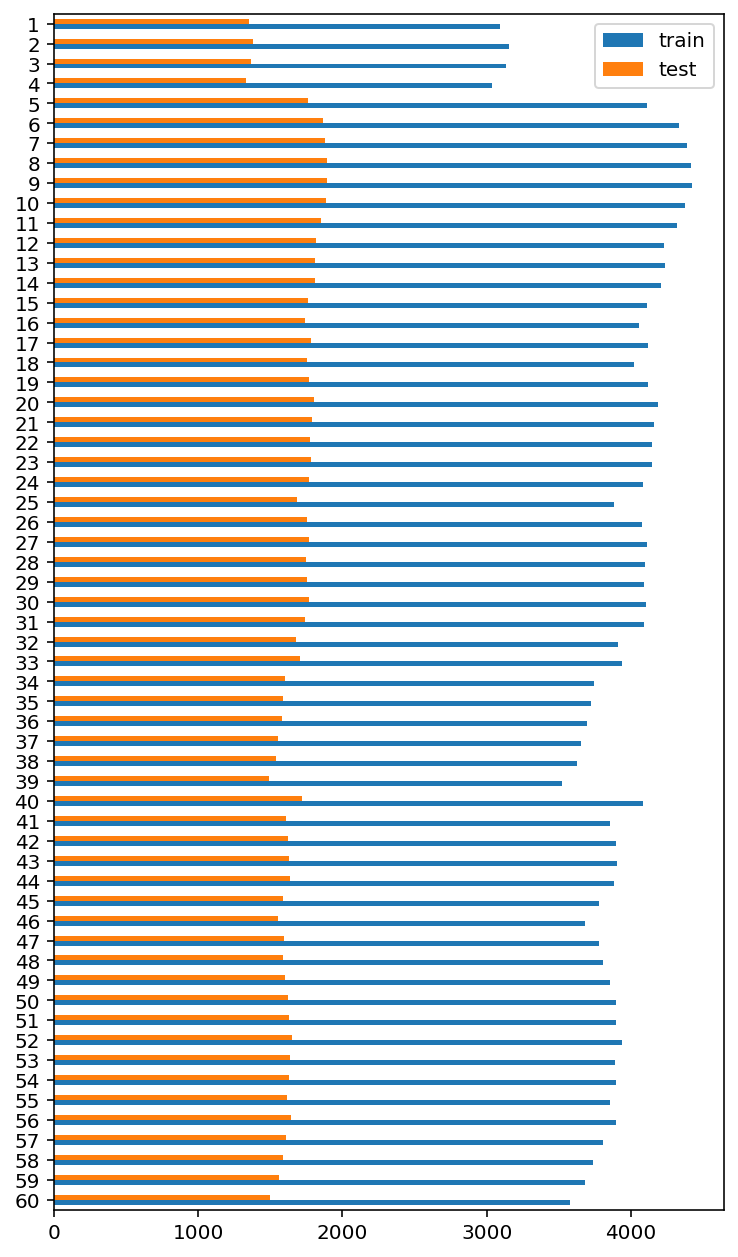

In [ ]:
pd.DataFrame([train_df.day.value_counts(), test_df.day.value_counts()],
             index=['train', 'test']).T.sort_index(ascending=False).plot.barh(figsize=(6, 11));

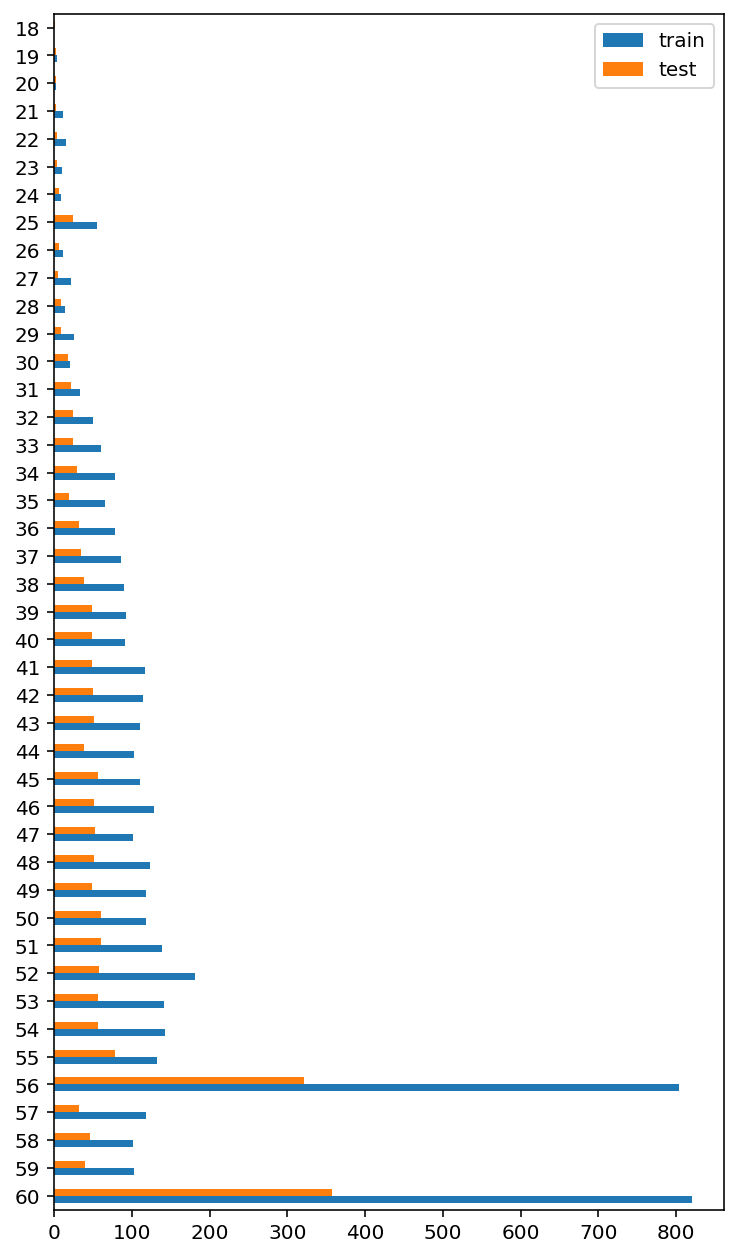

In [ ]:
pd.DataFrame(
    [train_df.groupby('product_id')['day'].nunique().value_counts(),
     test_df.groupby('product_id')['day'].nunique().value_counts()],
  index=['train', 'test']).T.sort_index(ascending=False).plot.barh(figsize=(6, 11));

There should be no null values:

In [ ]:
train_df.day.isna().any()

False

In [ ]:
test_df.day.isna().any()

False

Check if we have information for contiguous days per each product_id:

In [ ]:
train_df.groupby('product_id')['day'].unique().map(lambda ds: len(ds) == max(ds) - min(ds) + 1).mean()

0.4667648296171645

In [ ]:
test_df.groupby('product_id')['day'].unique().map(lambda ds: len(ds) == max(ds) - min(ds) + 1).mean()

0.45682041216879293

Only ~46% of products in the dataset have information for contiguous days.

In [ ]:
train_df

day  product_id  ... promotion_sold_count  normal_sold_count
0        48       54457  ...                  NaN                2.0
1        47       54457  ...                  NaN                3.0
2        46       54457  ...                  NaN                NaN
3        45       54457  ...                  NaN                2.0
4        44       54457  ...                  NaN                1.0
...     ...         ...  ...                  ...                ...
235478   41    15513291  ...                  NaN                NaN
235479   30    15513291  ...                  NaN                1.0
235480   35    15513291  ...                  NaN                NaN
235481   45    15513291  ...                  NaN                NaN
235482   53    15513291  ...                  NaN                NaN

[235483 rows x 29 columns]

In [ ]:
train_df.groupby('product_id')['day'].describe()

count       mean        std   min    25%   50%    75%   max
product_id                                                             
54457        54.0  31.870370  16.270179   5.0  18.25  31.5  44.75  60.0
84321        56.0  32.500000  16.309506   5.0  18.75  32.5  46.25  60.0
86054        56.0  32.500000  16.309506   5.0  18.75  32.5  46.25  60.0
86099        52.0  34.500000  15.154757   9.0  21.75  34.5  47.25  60.0
86213        48.0  29.895833  16.172264   5.0  16.75  28.5  40.25  60.0
...           ...        ...        ...   ...    ...   ...    ...   ...
15435305     33.0  44.000000   9.669540  28.0  36.00  44.0  52.00  60.0
15435312     32.0  44.500000   9.380832  29.0  36.75  44.5  52.25  60.0
15464235     32.0  44.500000   9.380832  29.0  36.75  44.5  52.25  60.0
15513274     31.0  45.000000   9.092121  30.0  37.50  45.0  52.50  60.0
15513291     31.0  45.000000   9.092121  30.0  37.50  45.0  52.50  60.0

[4754 rows x 8 columns]

In [ ]:
train_df.groupby('product_id')['day'].unique().map(lambda ds: (min(ds), max(ds), [i for i in range(min(ds), max(ds)+1) if i not in ds]))

product_id
54457                               (5, 60, [49, 50])
84321                                     (5, 60, [])
86054                                     (5, 60, [])
86099                                     (9, 60, [])
86213       (5, 60, [44, 45, 46, 48, 49, 50, 51, 52])
                              ...                    
15435305                                 (28, 60, [])
15435312                                 (29, 60, [])
15464235                                 (29, 60, [])
15513274                                 (30, 60, [])
15513291                                 (30, 60, [])
Name: day, Length: 4754, dtype: object

## product_id

In [ ]:
train_df.product_id.value_counts().plot.hist(bins=42);

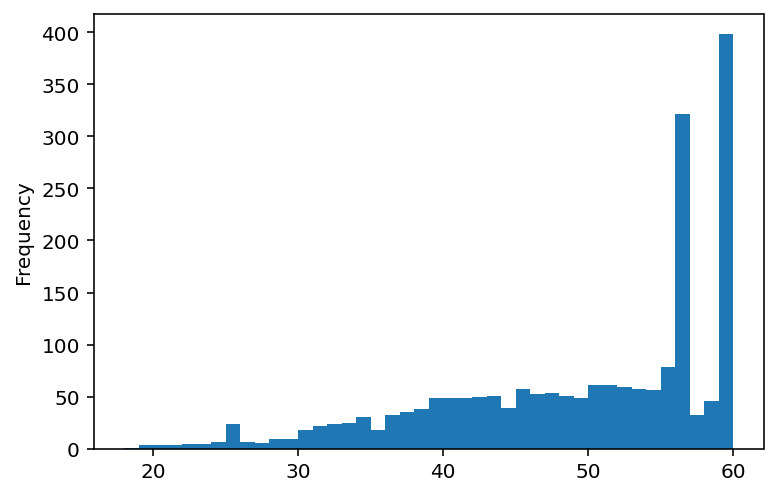

In [ ]:
test_df.product_id.value_counts().plot.hist(bins=42);

There should be no nulls:

In [ ]:
train_df.product_id.isna().any()

False

In [ ]:
test_df.product_id.isna().any()

False

There should be only no duplicate days for each product_id:

In [ ]:
train_df[train_df[['day', 'product_id']].duplicated(keep=False)].sort_values(['product_id', 'day'])

day  product_id  ... promotion_sold_count  normal_sold_count
14005    4      317418  ...                  NaN               22.0
14042    4      317418  ...                  NaN               22.0
14006    5      317418  ...                  NaN               15.0
14054    5      317418  ...                  NaN               15.0
14007    6      317418  ...                  NaN               11.0
14039    6      317418  ...                  NaN               11.0
14008    7      317418  ...                  NaN               12.0
14055    7      317418  ...                  NaN               12.0
14009    8      317418  ...                  NaN                2.0
14017    8      317418  ...                  NaN                2.0
14010    9      317418  ...                  NaN               10.0
14032    9      317418  ...                  NaN               10.0
14011   10      317418  ...                  NaN                5.0
14051   10      317418  ...                  NaN                5.0
14012   11      317418  ...                  NaN               10.0
14030   11      317418  ...                  NaN               10.0

[16 rows x 29 columns]

In [ ]:
test_df[test_df[['day', 'product_id']].duplicated(keep=False)].sort_values(['product_id', 'day'])

day  product_id  ... promotion_sold_count  normal_sold_count
54310   32      138734  ...                 -1.0               -1.0
54327   32      138734  ...                 -1.0               -1.0
56256   33      138734  ...                 -1.0               -1.0
56270   33      138734  ...                 -1.0               -1.0
58416   34      138734  ...                 -1.0               -1.0
58465   34      138734  ...                 -1.0               -1.0
59824   35      138734  ...                 -1.0               -1.0
59835   35      138734  ...                 -1.0               -1.0
61553   36      138734  ...                 -1.0               -1.0
61631   36      138734  ...                 -1.0               -1.0
62814   37      138734  ...                 -1.0               -1.0
63148   37      138734  ...                 -1.0               -1.0
64712   38      138734  ...                 -1.0               -1.0
64739   38      138734  ...                 -1.0               -1.0
65735   39      138734  ...                 -1.0               -1.0
65762   39      138734  ...                 -1.0               -1.0
66626   40      138734  ...                 -1.0               -1.0
68265   40      138734  ...                 -1.0               -1.0
68709   41      138734  ...                 -1.0               -1.0
68715   41      138734  ...                 -1.0               -1.0
70088   42      138734  ...                 -1.0               -1.0
71042   42      138734  ...                 -1.0               -1.0
72440   43      138734  ...                 -1.0               -1.0
72798   43      138734  ...                 -1.0               -1.0
73197   44      138734  ...                 -1.0               -1.0
73485   44      138734  ...                 -1.0               -1.0
75514   45      138734  ...                 -1.0               -1.0
75665   45      138734  ...                 -1.0               -1.0
76789   46      138734  ...                 -1.0               -1.0
76885   46      138734  ...                 -1.0               -1.0
77945   47      138734  ...                 -1.0               -1.0
78548   47      138734  ...                 -1.0               -1.0
80379   48      138734  ...                 -1.0               -1.0
80716   48      138734  ...                 -1.0               -1.0

[34 rows x 29 columns]

In [ ]:
train_df.drop_duplicates(['day', 'product_id'], inplace=True)
test_df.drop_duplicates(['day', 'product_id'], inplace=True)

In [ ]:
train_df[['day', 'product_id']].duplicated(keep=False).any()

False

In [ ]:
test_df[['day', 'product_id']].duplicated(keep=False).any()

False

## cat_name

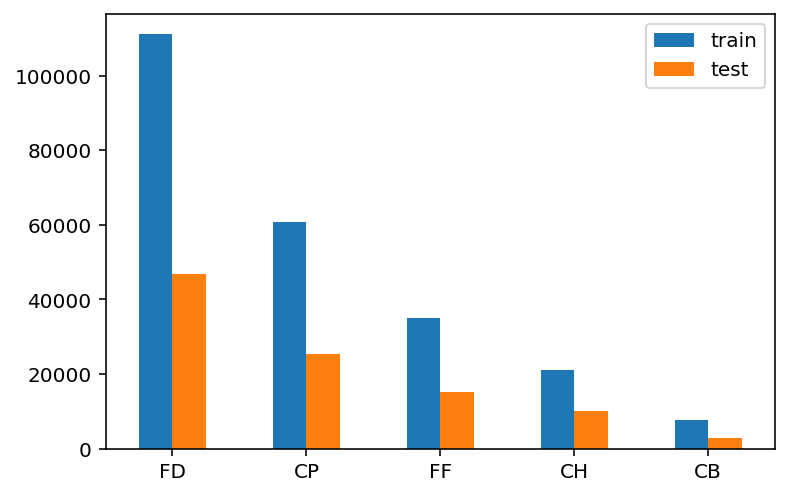

In [ ]:
pd.DataFrame([train_df.cat_name.value_counts(), test_df.cat_name.value_counts()],
             index=['train', 'test']).T.plot.bar(rot=0);

There should be no nulls:

In [ ]:
train_df.cat_name.isna().any()

False

In [ ]:
test_df.cat_name.isna().any()

False

## leaf_cat_id

In [ ]:
train_df.leaf_cat_id.nunique()

154

In [ ]:
test_df.leaf_cat_id.nunique()

138

In [ ]:
np.setdiff1d(train_df.leaf_cat_id.unique(), test_df.leaf_cat_id.unique())

array([16976, 17595, 17596, 17604, 17643, 17657, 17662, 17694, 17699,
       17712, 17716, 17725, 17767, 17915, 18015, 18039, 18040, 18089,
       19560, 20012, 20336, 20965])

In [ ]:
np.setdiff1d(test_df.leaf_cat_id.unique(), train_df.leaf_cat_id.unique())

array([17655, 17668, 17695, 17732, 19628, 21297])

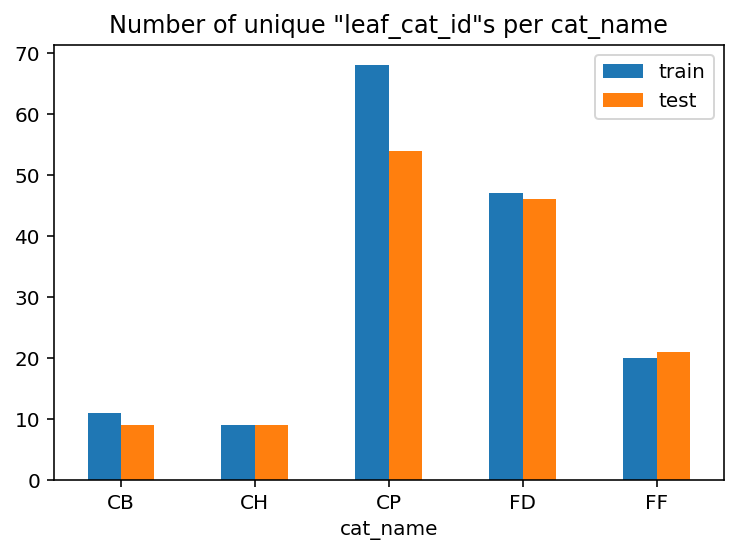

In [ ]:
pd.DataFrame([train_df.groupby('cat_name')['leaf_cat_id'].nunique(), test_df.groupby('cat_name')['leaf_cat_id'].nunique()],
             index=['train', 'test']).T.plot.bar(rot=0);
plt.title('Number of unique "leaf_cat_id"s per cat_name');

There should be no nulls:

In [ ]:
train_df.leaf_cat_id.isna().any()

False

In [ ]:
test_df.leaf_cat_id.isna().any()

False

## live_rate

In [ ]:
train_df.live_rate.describe()

count    235475.000000
mean          0.957977
std           0.157895
min           0.040000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: live_rate, dtype: float64

In [ ]:
test_df.live_rate.describe()

count    100379.000000
mean          0.956988
std           0.160216
min           0.040000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: live_rate, dtype: float64

There should be no nulls:

In [ ]:
train_df.live_rate.isna().any()

False

In [ ]:
test_df.live_rate.isna().any()

False

## product_sat_score

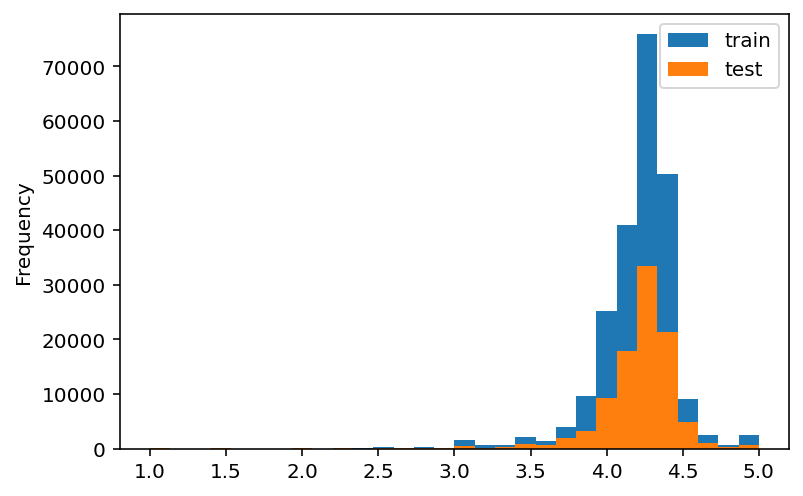

In [ ]:
train_df.product_sat_score.plot.hist(bins=30, label='train');
test_df.product_sat_score.plot.hist(bins=30, label='test');
plt.legend();

## product_sat_count

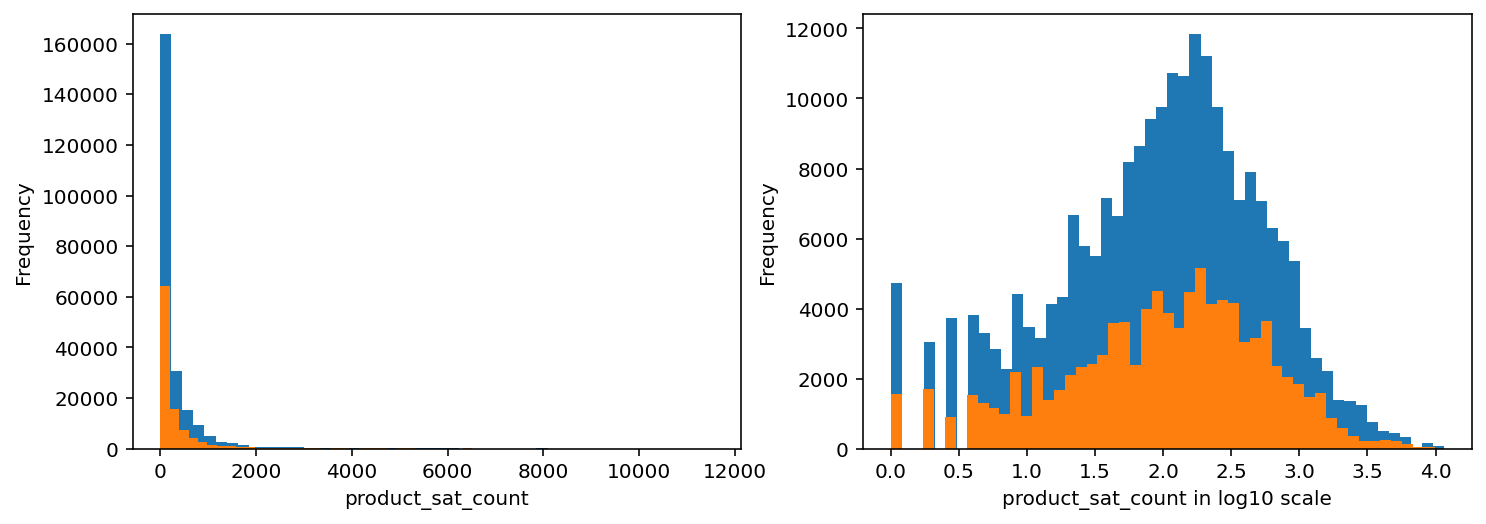

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df.product_sat_count.plot.hist(ax=ax[0], bins=50);
test_df.product_sat_count.plot.hist(ax=ax[0], bins=50);
ax[0].set_xlabel('product_sat_count');

np.log10(train_df[train_df.product_sat_count > 0].product_sat_count).plot.hist(ax=ax[1], bins=50);
np.log10(test_df[test_df.product_sat_count > 0].product_sat_count).plot.hist(ax=ax[1], bins=50);
ax[1].set_xlabel('product_sat_count in log10 scale');

There should be no nulls for this column:

In [ ]:
train_df.product_sat_count.isna().any()

False

In [ ]:
test_df.product_sat_count.isna().any()

False

## amazing_day_rate

In [ ]:
train_df.amazing_day_rate.describe()

count    5030.000000
mean        0.542544
std         0.488188
min         0.019400
25%         0.020800
50%         1.000000
75%         1.000000
max         1.000000
Name: amazing_day_rate, dtype: float64

In [ ]:
test_df.amazing_day_rate.describe()

count    2284.000000
mean        0.539671
std         0.488295
min         0.020800
25%         0.020800
50%         1.000000
75%         1.000000
max         1.000000
Name: amazing_day_rate, dtype: float64

## amazing_price_segment

In [ ]:
train_df.amazing_price_segment.describe()

count    5030.000000
mean     1317.425249
std        74.764762
min      1048.000000
25%      1263.000000
50%      1308.000000
75%      1370.000000
max      1533.000000
Name: amazing_price_segment, dtype: float64

In [ ]:
test_df.amazing_price_segment.describe()

count    2284.000000
mean     1317.814799
std        70.628381
min      1048.000000
25%      1279.000000
50%      1311.000000
75%      1359.000000
max      1558.000000
Name: amazing_price_segment, dtype: float64

## amazing_discount

In [ ]:
train_df.amazing_discount.describe()

count    5030.000000
mean        0.294693
std         0.106493
min         0.020472
25%         0.205645
50%         0.283333
75%         0.366812
max         0.865940
Name: amazing_discount, dtype: float64

In [ ]:
test_df.amazing_discount.describe()

count    2284.000000
mean        0.295139
std         0.107033
min         0.099198
25%         0.200000
50%         0.301370
75%         0.367722
max         0.673333
Name: amazing_discount, dtype: float64

## amazing_order_limit

In [ ]:
train_df.amazing_order_limit.describe()

count    5027.000000
mean        4.844440
std         0.721225
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: amazing_order_limit, dtype: float64

In [ ]:
test_df.amazing_order_limit.describe()

count    2281.000000
mean        4.880754
std         0.640574
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: amazing_order_limit, dtype: float64

## amazing_proposed_stock

In [ ]:
train_df.amazing_proposed_stock.describe()

count    5030.000000
mean      687.836779
std       620.352606
min         6.000000
25%       300.000000
50%       500.000000
75%       900.000000
max      8000.000000
Name: amazing_proposed_stock, dtype: float64

In [ ]:
test_df.amazing_proposed_stock.describe()

count     2284.00000
mean       717.26620
std        786.14679
min          2.00000
25%        300.00000
50%        500.00000
75%        809.00000
max      15000.00000
Name: amazing_proposed_stock, dtype: float64

## promotion_day_rate

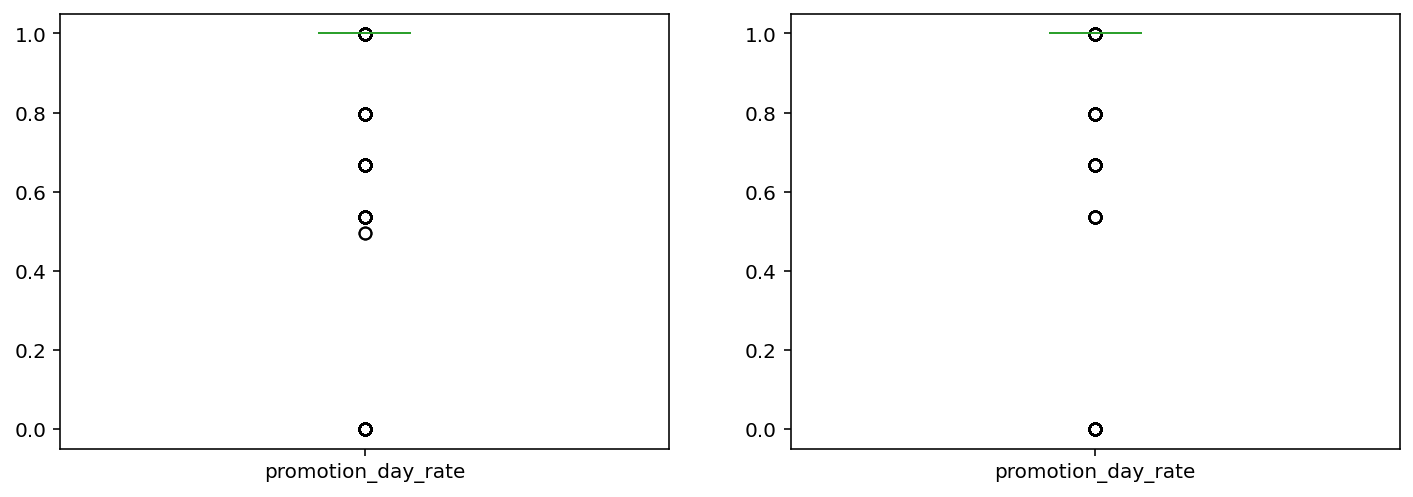

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df.promotion_day_rate.plot.box(ax=ax[0]);

test_df.promotion_day_rate.plot.box(ax=ax[1]);

In [ ]:
train_df.promotion_day_rate.describe()

count    49543.000000
mean         0.929024
std          0.255606
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: promotion_day_rate, dtype: float64

In [ ]:
test_df.promotion_day_rate.describe()

count    21292.000000
mean         0.929050
std          0.255603
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: promotion_day_rate, dtype: float64

## promotion_price_segment

In [ ]:
train_df.promotion_price_segment.describe()

count    49543.000000
mean      1156.920574
std        330.980507
min          0.000000
25%       1164.000000
50%       1228.000000
75%       1303.000000
max       1586.000000
Name: promotion_price_segment, dtype: float64

In [ ]:
test_df.promotion_price_segment.describe()

count    21292.000000
mean      1156.950733
std        329.574759
min          0.000000
25%       1170.000000
50%       1225.000000
75%       1304.000000
max       1584.000000
Name: promotion_price_segment, dtype: float64

## promotion_discount

In [ ]:
train_df.promotion_discount.describe()

count    49543.000000
mean         0.170291
std          0.095529
min          0.000000
25%          0.100000
50%          0.155660
75%          0.219024
max          0.721938
Name: promotion_discount, dtype: float64

In [ ]:
test_df.promotion_discount.describe()

count    21292.000000
mean         0.173315
std          0.097091
min          0.000000
25%          0.100000
50%          0.170677
75%          0.220000
max          0.673450
Name: promotion_discount, dtype: float64

## promotion_order_limit

In [ ]:
train_df.promotion_order_limit.describe()

count    49183.000000
mean         9.256633
std          5.588568
min          0.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         30.000000
Name: promotion_order_limit, dtype: float64

In [ ]:
test_df.promotion_order_limit.describe()

count    21191.000000
mean         9.361899
std          5.521426
min          0.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         30.000000
Name: promotion_order_limit, dtype: float64

## promotion_proposed_stock

In [ ]:
train_df.promotion_proposed_stock.describe()

count    49543.000000
mean      1029.087157
std       2063.299665
min          0.000000
25%        115.000000
50%       1000.000000
75%       1000.000000
max      84000.000000
Name: promotion_proposed_stock, dtype: float64

In [ ]:
test_df.promotion_proposed_stock.describe()

count    21292.000000
mean      1150.303682
std       2203.941794
min          0.000000
25%        144.000000
50%       1000.000000
75%       1000.000000
max      29500.000000
Name: promotion_proposed_stock, dtype: float64

## comments_counts_7

In [ ]:
train_df.comments_counts_7.describe()

count    147921.000000
mean          5.250539
std           7.667646
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         160.000000
Name: comments_counts_7, dtype: float64

In [ ]:
test_df.comments_counts_7.describe()

count    63432.000000
mean         5.280789
std          7.511254
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        118.000000
Name: comments_counts_7, dtype: float64

## rec_comments_count_7

In [ ]:
train_df.rec_comments_count_7.describe()

count    147921.000000
mean          4.397875
std           6.717135
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         140.000000
Name: rec_comments_count_7, dtype: float64

In [ ]:
test_df.rec_comments_count_7.describe()

count    63432.000000
mean         4.411464
std          6.500486
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        100.000000
Name: rec_comments_count_7, dtype: float64

## dkp_amazing_notif_count_7

In [ ]:
train_df.dkp_amazing_notif_count_7.describe()

count    14555.000000
mean        10.737272
std         17.878868
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max        243.000000
Name: dkp_amazing_notif_count_7, dtype: float64

In [ ]:
test_df.dkp_amazing_notif_count_7.describe()

count    6682.000000
mean        9.115983
std        18.016437
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max       247.000000
Name: dkp_amazing_notif_count_7, dtype: float64

## normal_order_limit

In [ ]:
train_df.normal_order_limit.describe()

count    68201.000000
mean        74.180203
std        171.308985
min          0.000000
25%         10.000000
50%         30.000000
75%         65.000000
max       5790.000000
Name: normal_order_limit, dtype: float64

In [ ]:
test_df.normal_order_limit.describe()

count    29980.000000
mean        68.501601
std        138.935646
min          0.000000
25%         10.000000
50%         30.000000
75%         65.000000
max       5970.000000
Name: normal_order_limit, dtype: float64

## normal_price_segment

In [ ]:
train_df.normal_price_segment.describe()

count    68201.000000
mean      1251.638451
std         89.863187
min        940.000000
25%       1191.000000
50%       1251.000000
75%       1306.000000
max       1586.000000
Name: normal_price_segment, dtype: float64

In [ ]:
test_df.normal_price_segment.describe()

count    29980.000000
mean      1250.796298
std         89.375316
min        921.000000
25%       1191.000000
50%       1253.000000
75%       1306.000000
max       1584.000000
Name: normal_price_segment, dtype: float64

## normal_discount

In [ ]:
train_df.normal_discount.describe()

count    68201.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: normal_discount, dtype: float64

In [ ]:
test_df.normal_discount.describe()

count    29980.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: normal_discount, dtype: float64

There is no discount out of promotion and amazing at all. So we delete this feature from the dataset.

In [ ]:
train_df.drop('normal_discount', axis=1, inplace=True)
test_df.drop('normal_discount', axis=1, inplace=True)

## holiday

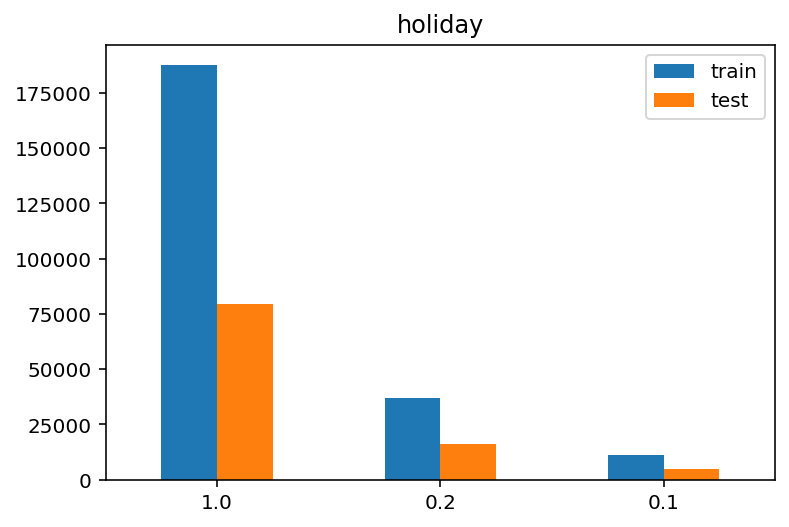

In [ ]:
pd.DataFrame([train_df.holiday.value_counts(), test_df.holiday.value_counts()],
             index=['train', 'test']).T.plot.bar(rot=0);
plt.title('holiday');

There should be no null values:

In [ ]:
train_df.holiday.isna().any()

False

In [ ]:
test_df.holiday.isna().any()

False

## warehouse1_share & warehouse2_share

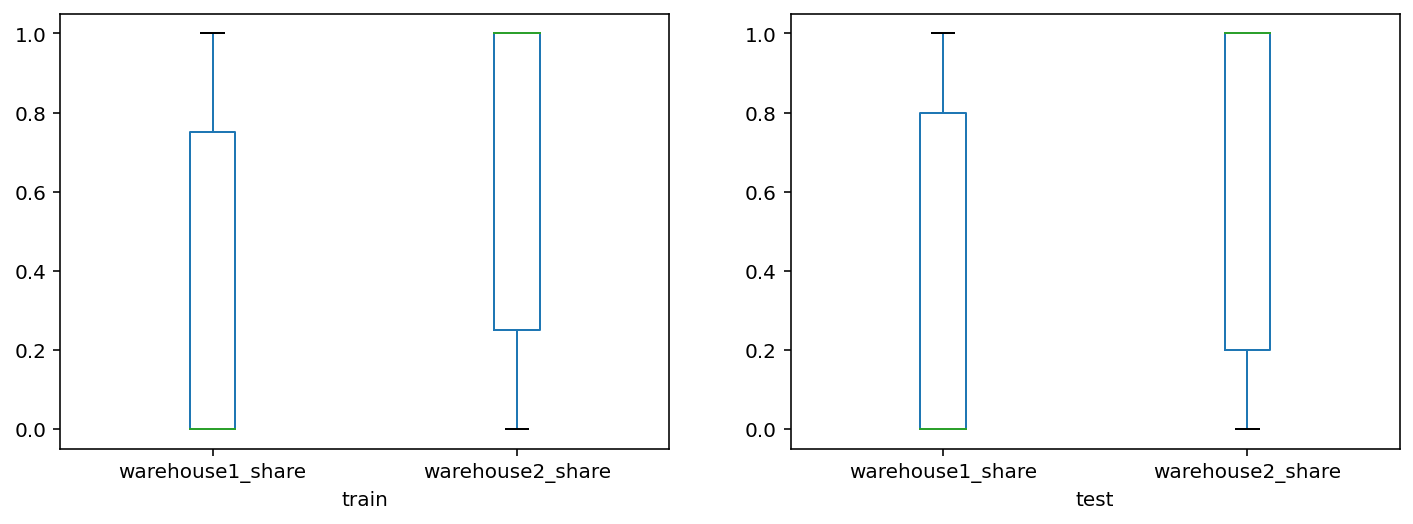

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df[['warehouse1_share', 'warehouse2_share']].plot.box(ax=ax[0]);
ax[0].set_xlabel('train');

test_df[test_df.warehouse1_share > -1][['warehouse1_share', 'warehouse2_share']].plot.box(ax=ax[1]);
ax[1].set_xlabel('test');

In [ ]:
train_df[['warehouse1_share', 'warehouse2_share']].sum(1).value_counts()

0.00000    136267
1.00000     97760
1.00000      1430
1.00001         9
1.00000         6
1.00001         3
dtype: int64

In [ ]:
test_df[['warehouse1_share', 'warehouse2_share']].sum(1).value_counts()

-2.0    48289
 0.0    27009
 1.0    24828
 1.0      253
dtype: int64

## amazing_sold_count

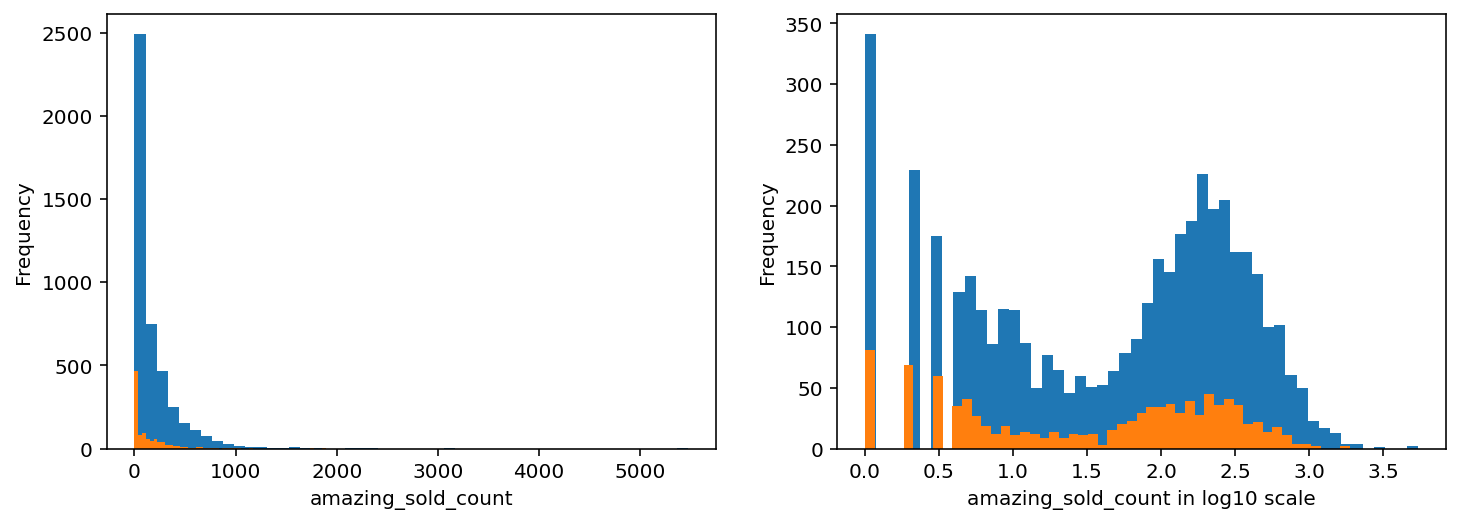

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df.amazing_sold_count.plot.hist(ax=ax[0], bins=50);
test_df[test_df.amazing_sold_count > -1].amazing_sold_count.plot.hist(ax=ax[0], bins=50);
ax[0].set_xlabel('amazing_sold_count');

np.log10(train_df.amazing_sold_count).plot.hist(ax=ax[1], bins=50);
np.log10(test_df[test_df.amazing_sold_count > -1].amazing_sold_count).plot.hist(ax=ax[1], bins=50);
ax[1].set_xlabel('amazing_sold_count in log10 scale');

There should be on zeros:

In [ ]:
(train_df.amazing_sold_count == 0).sum()

0

In [ ]:
(test_df.amazing_sold_count == 0).sum()

0

## promotion_sold_count

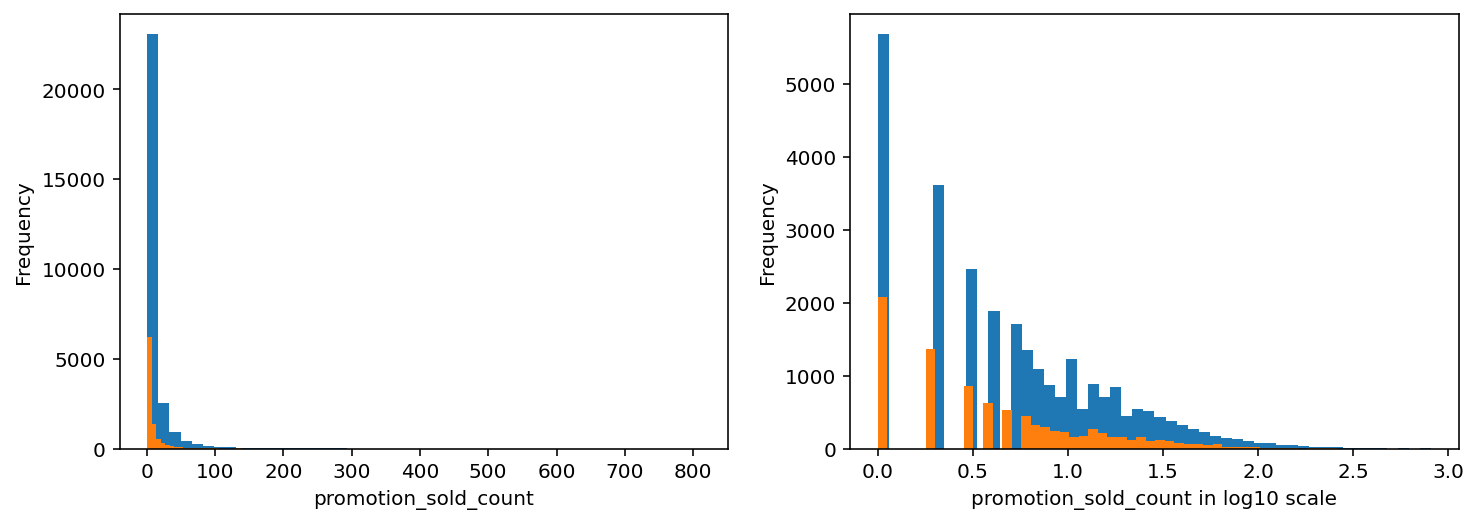

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df.promotion_sold_count.plot.hist(ax=ax[0], bins=50);
test_df[test_df.promotion_sold_count > -1].promotion_sold_count.plot.hist(ax=ax[0], bins=50);
ax[0].set_xlabel('promotion_sold_count');

np.log10(train_df.promotion_sold_count).plot.hist(ax=ax[1], bins=50);
np.log10(test_df[test_df.promotion_sold_count > -1].promotion_sold_count).plot.hist(ax=ax[1], bins=50);
ax[1].set_xlabel('promotion_sold_count in log10 scale');

There should be on zeros:

In [ ]:
(train_df.promotion_sold_count == 0).sum()

0

In [ ]:
(test_df.promotion_sold_count == 0).sum()

0

## normal_sold_count

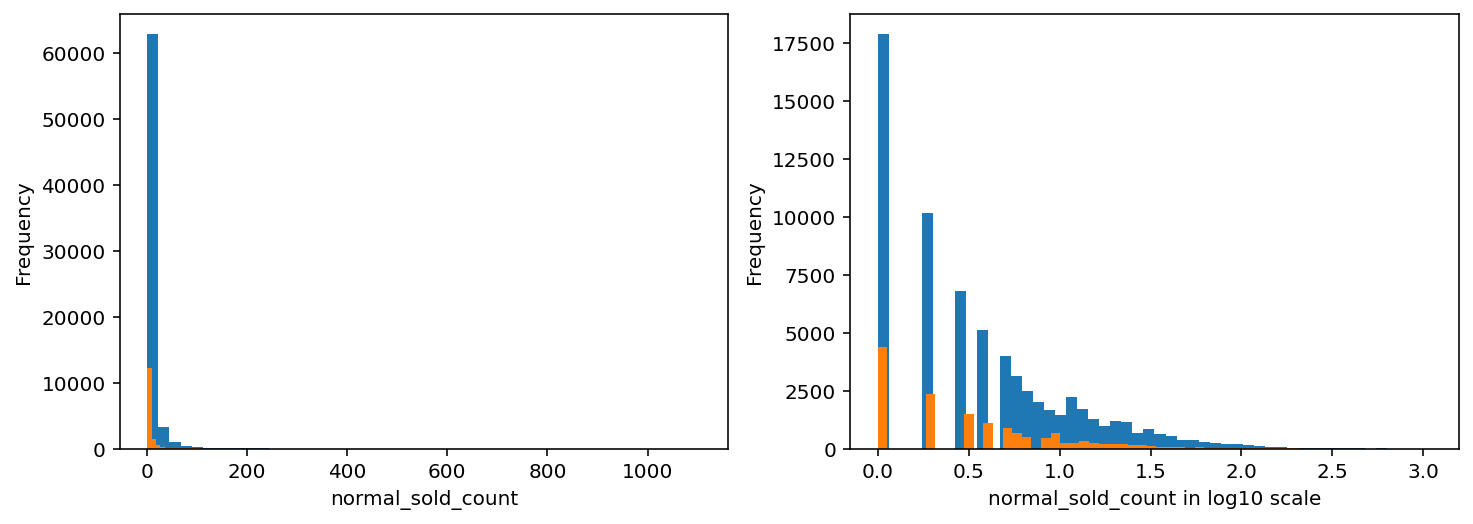

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4));

train_df.normal_sold_count.plot.hist(ax=ax[0], bins=50);
test_df[test_df.normal_sold_count > -1].normal_sold_count.plot.hist(ax=ax[0], bins=50);
ax[0].set_xlabel('normal_sold_count');

np.log10(train_df.normal_sold_count).plot.hist(ax=ax[1], bins=50);
np.log10(test_df[test_df.normal_sold_count > -1].normal_sold_count).plot.hist(ax=ax[1], bins=50);
ax[1].set_xlabel('normal_sold_count in log10 scale');

There should be on zeros:

In [ ]:
(train_df.normal_sold_count == 0).sum()

0

In [ ]:
(test_df.normal_sold_count == 0).sum()

0

# 2. Dealing with missing values

## Null rates

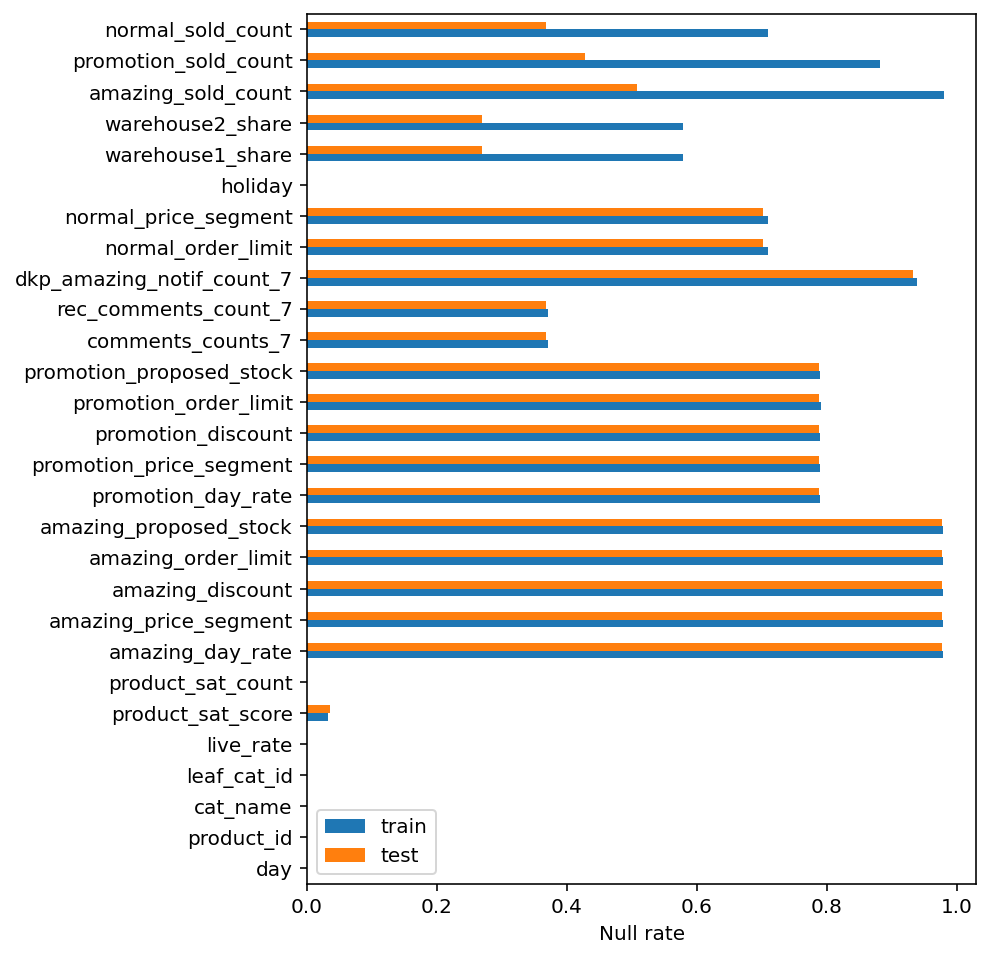

In [ ]:
pd.DataFrame([train_df.isna().mean(0), test_df.isna().mean(0)],
             index=['train', 'test']).T.plot.barh(rot=0, figsize=(6, 8));
plt.xlabel('Null rate');

## Replacing with Zero

For some columns, null values mean zero. So we replace nulls with zeros for those:

In [ ]:
cols_null_zero = [
 'comments_counts_7', 'rec_comments_count_7', 'dkp_amazing_notif_count_7',
 'amazing_day_rate', 'amazing_price_segment', 'amazing_discount',
 'amazing_order_limit', 'amazing_proposed_stock',
 'promotion_day_rate', 'promotion_price_segment', 'promotion_discount',
 'promotion_order_limit', 'promotion_proposed_stock',
 'normal_order_limit', 'normal_price_segment',
 'warehouse1_share', 'warehouse2_share',
 'amazing_sold_count', 'promotion_sold_count', 'normal_sold_count'
]

In [ ]:
train_df[cols_null_zero] = train_df[cols_null_zero].fillna(0)
test_df[cols_null_zero] = test_df[cols_null_zero].fillna(0)

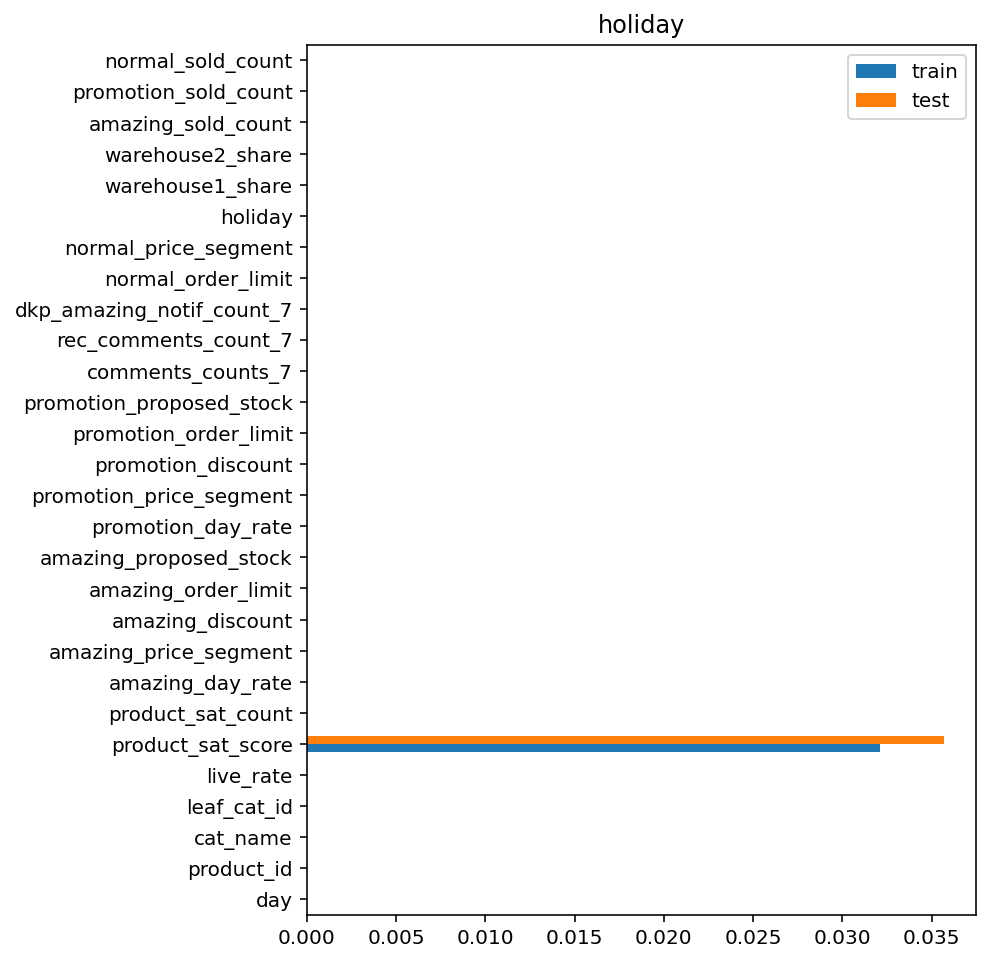

In [ ]:
pd.DataFrame([train_df.isna().mean(0), test_df.isna().mean(0)],
             index=['train', 'test']).T.plot.barh(rot=0, figsize=(6, 8));
plt.title('holiday');

Replacing with median:

In [ ]:
cols_null_median = [
  'product_sat_score'
]

In [ ]:
train_df[cols_null_median]

product_sat_score
0                  4.1353
1                  4.1353
2                  4.1343
3                  4.1343
4                  4.1328
...                   ...
235478                NaN
235479                NaN
235480                NaN
235481                NaN
235482                NaN

[235475 rows x 1 columns]

In [ ]:
train_median = train_df[cols_null_median].median(axis=0)
train_df[cols_null_median] = train_df[cols_null_median].fillna(train_median)
test_df[cols_null_median] = test_df[cols_null_median].fillna(train_median)

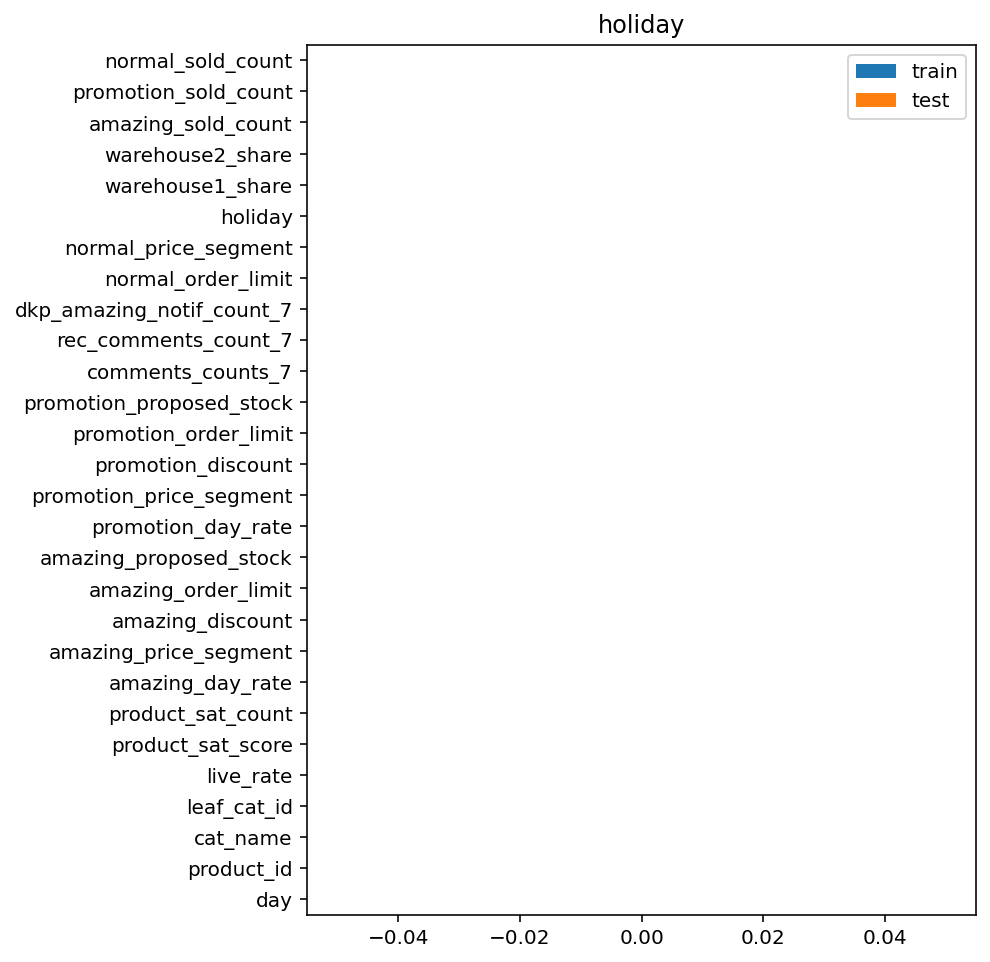

In [ ]:
pd.DataFrame([train_df.isna().mean(0), test_df.isna().mean(0)],
             index=['train', 'test']).T.plot.barh(rot=0, figsize=(6, 8));
plt.title('holiday');

# 3. Categorical to numerical conversion

In [ ]:
cat_cols = ['holiday', 'cat_name', 'leaf_cat_id']
for col in cat_cols:
  train_df[col] = train_df[col].astype('category')
  test_df[col] = test_df[col].astype('category')

In [ ]:
train_one_hot = pd.get_dummies(train_df[cat_cols])
train_df = pd.concat([train_df.drop(cat_cols, axis=1), train_one_hot], axis=1)
train_df.head()

day  product_id  ...  leaf_cat_id_21245  leaf_cat_id_21298
0   48       54457  ...                  0                  0
1   47       54457  ...                  0                  0
2   46       54457  ...                  0                  0
3   45       54457  ...                  0                  0
4   44       54457  ...                  0                  0

[5 rows x 187 columns]

In [ ]:
test_one_hot = pd.get_dummies(test_df[cat_cols])
test_df = pd.concat([test_df.drop(cat_cols, axis=1), test_one_hot], axis=1)
test_df.head()

day  product_id  ...  leaf_cat_id_21297  leaf_cat_id_21298
0    1     3946952  ...                  0                  0
1    1    12145670  ...                  0                  0
2    1    14032418  ...                  0                  0
3    1    14232904  ...                  0                  0
4    1     9669857  ...                  0                  0

[5 rows x 171 columns]

These columns are either available in train or test data (not both), so we remove them:

In [ ]:
diff_one_hot_columns = train_one_hot.columns.symmetric_difference(test_one_hot.columns)
diff_one_hot_columns

Index(['leaf_cat_id_16976', 'leaf_cat_id_17595', 'leaf_cat_id_17596',
       'leaf_cat_id_17604', 'leaf_cat_id_17643', 'leaf_cat_id_17655',
       'leaf_cat_id_17657', 'leaf_cat_id_17662', 'leaf_cat_id_17668',
       'leaf_cat_id_17694', 'leaf_cat_id_17695', 'leaf_cat_id_17699',
       'leaf_cat_id_17712', 'leaf_cat_id_17716', 'leaf_cat_id_17725',
       'leaf_cat_id_17732', 'leaf_cat_id_17767', 'leaf_cat_id_17915',
       'leaf_cat_id_18015', 'leaf_cat_id_18039', 'leaf_cat_id_18040',
       'leaf_cat_id_18089', 'leaf_cat_id_19560', 'leaf_cat_id_19628',
       'leaf_cat_id_20012', 'leaf_cat_id_20336', 'leaf_cat_id_20965',
       'leaf_cat_id_21297'],
      dtype='object')

In [ ]:
train_df = train_df.drop(diff_one_hot_columns.intersection(train_df.columns), axis=1)
test_df = test_df.drop(diff_one_hot_columns.intersection(test_df.columns), axis=1)
train_df.shape, test_df.shape

((235475, 165), (100379, 165))

# 4. Feature Normalization

In [ ]:
train_df.set_index(['product_id', 'day'], inplace=True)
test_df.set_index(['product_id', 'day'], inplace=True)

In [ ]:
train_df.sort_index(inplace=True)
test_df.sort_index(inplace=True)

In [ ]:
train_full_index = pd.MultiIndex.from_product([train_df.index.get_level_values(0).unique(), range(1, 61)])
test_full_index = pd.MultiIndex.from_product([test_df.index.get_level_values(0).unique(), range(1, 61)])

In [ ]:
train_df = train_df.reindex(train_full_index)
test_df = test_df.reindex(test_full_index)

In [ ]:
train_df

live_rate  ...  leaf_cat_id_21298
product_id                ...                   
54457      1         NaN  ...                NaN
           2         NaN  ...                NaN
           3         NaN  ...                NaN
           4         NaN  ...                NaN
           5         1.0  ...                0.0
...                  ...  ...                ...
15513291   56        1.0  ...                0.0
           57        1.0  ...                0.0
           58        1.0  ...                0.0
           59        1.0  ...                0.0
           60        1.0  ...                0.0

[285240 rows x 163 columns]

In [ ]:
test_df

live_rate  ...  leaf_cat_id_21298
product_id                ...                   
54669      1         NaN  ...                NaN
           2         NaN  ...                NaN
           3         NaN  ...                NaN
           4         NaN  ...                NaN
           5         1.0  ...                0.0
...                  ...  ...                ...
15513318   56        1.0  ...                0.0
           57        1.0  ...                0.0
           58        1.0  ...                0.0
           59        1.0  ...                0.0
           60        1.0  ...                0.0

[122280 rows x 163 columns]

In [ ]:
train_df = train_df.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)
test_df = test_df.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)

In [ ]:
train_df

live_rate  ...  leaf_cat_id_21298
product_id                ...                   
54457      1         1.0  ...                0.0
           2         1.0  ...                0.0
           3         1.0  ...                0.0
           4         1.0  ...                0.0
           5         1.0  ...                0.0
...                  ...  ...                ...
15513291   56        1.0  ...                0.0
           57        1.0  ...                0.0
           58        1.0  ...                0.0
           59        1.0  ...                0.0
           60        1.0  ...                0.0

[285240 rows x 163 columns]

In [ ]:
test_df

live_rate  ...  leaf_cat_id_21298
product_id                ...                   
54669      1         1.0  ...                0.0
           2         1.0  ...                0.0
           3         1.0  ...                0.0
           4         1.0  ...                0.0
           5         1.0  ...                0.0
...                  ...  ...                ...
15513318   56        1.0  ...                0.0
           57        1.0  ...                0.0
           58        1.0  ...                0.0
           59        1.0  ...                0.0
           60        1.0  ...                0.0

[122280 rows x 163 columns]

In [ ]:
target_cols = ['normal_sold_count', 'promotion_sold_count', 'amazing_sold_count',
               'warehouse1_share', 'warehouse2_share']

In [ ]:
train_df_rolling_mean = train_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].mean()).shift(1)
train_df_rolling_std = train_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].std()).shift(1)
train_df_rolling_median = train_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].median()).shift(1)
train_df_rolling_min = train_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].min()).shift(1)
train_df_rolling_max = train_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].max()).shift(1)

test_df_rolling_mean = test_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].mean()).shift(1)
test_df_rolling_std = test_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].std()).shift(1)
test_df_rolling_median = test_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].median()).shift(1)
test_df_rolling_min = test_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].min()).shift(1)
test_df_rolling_max = test_df.groupby(level=0).apply(lambda x: x.rolling(30, min_periods=20)[target_cols].max()).shift(1)

In [ ]:
train_df_rolling_mean.columns = test_df_rolling_mean.columns = [f'{col}_rolling_mean' for col in train_df_rolling_mean.columns]
train_df_rolling_std.columns = test_df_rolling_std.columns = [f'{col}_rolling_std' for col in train_df_rolling_std.columns]
train_df_rolling_median.columns = test_df_rolling_median.columns = [f'{col}_rolling_median' for col in train_df_rolling_median.columns]
train_df_rolling_min.columns = test_df_rolling_min.columns = [f'{col}_rolling_min' for col in train_df_rolling_min.columns]
train_df_rolling_max.columns = test_df_rolling_max.columns = [f'{col}_rolling_max' for col in train_df_rolling_max.columns]

In [ ]:
train_labels_features = pd.concat([
  train_df_rolling_mean,
  train_df_rolling_std,
  train_df_rolling_median,
  train_df_rolling_min,
  train_df_rolling_max
], axis=1)

test_labels_features = pd.concat([
  test_df_rolling_mean,
  test_df_rolling_std,
  test_df_rolling_median,
  test_df_rolling_min,
  test_df_rolling_max
], axis=1)

In [ ]:
train_labels_features

normal_sold_count_rolling_mean  ...  warehouse2_share_rolling_max
product_id                                     ...                              
54457      1                              NaN  ...                           NaN
           2                              NaN  ...                           NaN
           3                              NaN  ...                           NaN
           4                              NaN  ...                           NaN
           5                              NaN  ...                           NaN
...                                       ...  ...                           ...
15513291   56                        0.166667  ...                           1.0
           57                        0.166667  ...                           1.0
           58                        0.166667  ...                           1.0
           59                        0.166667  ...                           1.0
           60                        0.166667  ...                           1.0

[285240 rows x 25 columns]

In [ ]:
test_labels_features

normal_sold_count_rolling_mean  ...  warehouse2_share_rolling_max
product_id                                     ...                              
54669      1                              NaN  ...                           NaN
           2                              NaN  ...                           NaN
           3                              NaN  ...                           NaN
           4                              NaN  ...                           NaN
           5                              NaN  ...                           NaN
...                                       ...  ...                           ...
15513318   56                       -0.933333  ...                           1.0
           57                       -0.933333  ...                           1.0
           58                       -0.933333  ...                           1.0
           59                       -0.933333  ...                           1.0
           60                       -0.933333  ...                           1.0

[122280 rows x 25 columns]

In [ ]:
train_df = pd.concat([train_df, train_labels_features], axis=1)
test_df = pd.concat([test_df, test_labels_features], axis=1)

In [ ]:
train_df

live_rate  ...  warehouse2_share_rolling_max
product_id                ...                              
54457      1         1.0  ...                           NaN
           2         1.0  ...                           NaN
           3         1.0  ...                           NaN
           4         1.0  ...                           NaN
           5         1.0  ...                           NaN
...                  ...  ...                           ...
15513291   56        1.0  ...                           1.0
           57        1.0  ...                           1.0
           58        1.0  ...                           1.0
           59        1.0  ...                           1.0
           60        1.0  ...                           1.0

[285240 rows x 188 columns]

In [ ]:
test_df

live_rate  ...  warehouse2_share_rolling_max
product_id                ...                              
54669      1         1.0  ...                           NaN
           2         1.0  ...                           NaN
           3         1.0  ...                           NaN
           4         1.0  ...                           NaN
           5         1.0  ...                           NaN
...                  ...  ...                           ...
15513318   56        1.0  ...                           1.0
           57        1.0  ...                           1.0
           58        1.0  ...                           1.0
           59        1.0  ...                           1.0
           60        1.0  ...                           1.0

[122280 rows x 188 columns]

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
x_train, y_train = train_df.drop(target_cols, axis=1), train_df[target_cols]
x_test, y_test = test_df.drop(target_cols, axis=1), test_df[target_cols]

In [ ]:
x_train.shape, x_test.shape

((194913, 183), (83557, 183))

In [ ]:
scaler = StandardScaler()
x_train_np = scaler.fit_transform(x_train)
x_test_np = scaler.transform(x_test)

In [ ]:
x_train = pd.DataFrame(x_train_np, index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(x_test_np, index=x_test.index, columns=x_test.columns)

In [ ]:
pca = PCA(2).fit(x_train)

In [ ]:
x_train_2d_pca = pca.transform(x_train)
x_test_2d_pca = pca.transform(x_test)

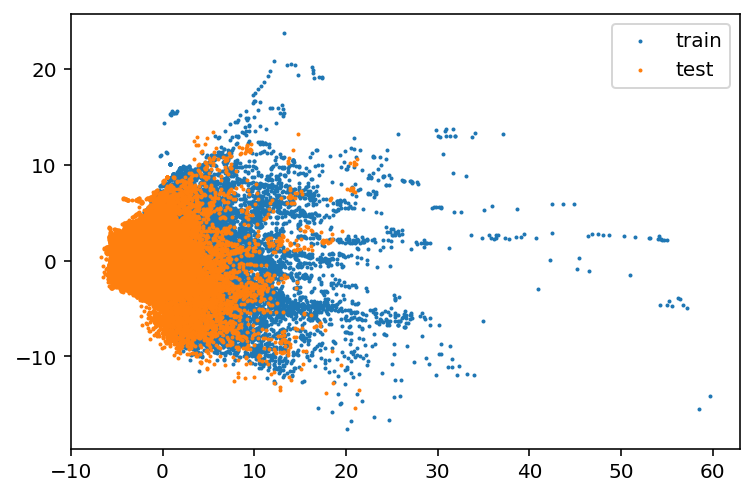

In [ ]:
plt.scatter(x_train_2d_pca[:, 0], x_train_2d_pca[:, 1], s=1, label='train');
plt.scatter(x_test_2d_pca[:, 0], x_test_2d_pca[:, 1], s=1, label='test');
plt.legend();

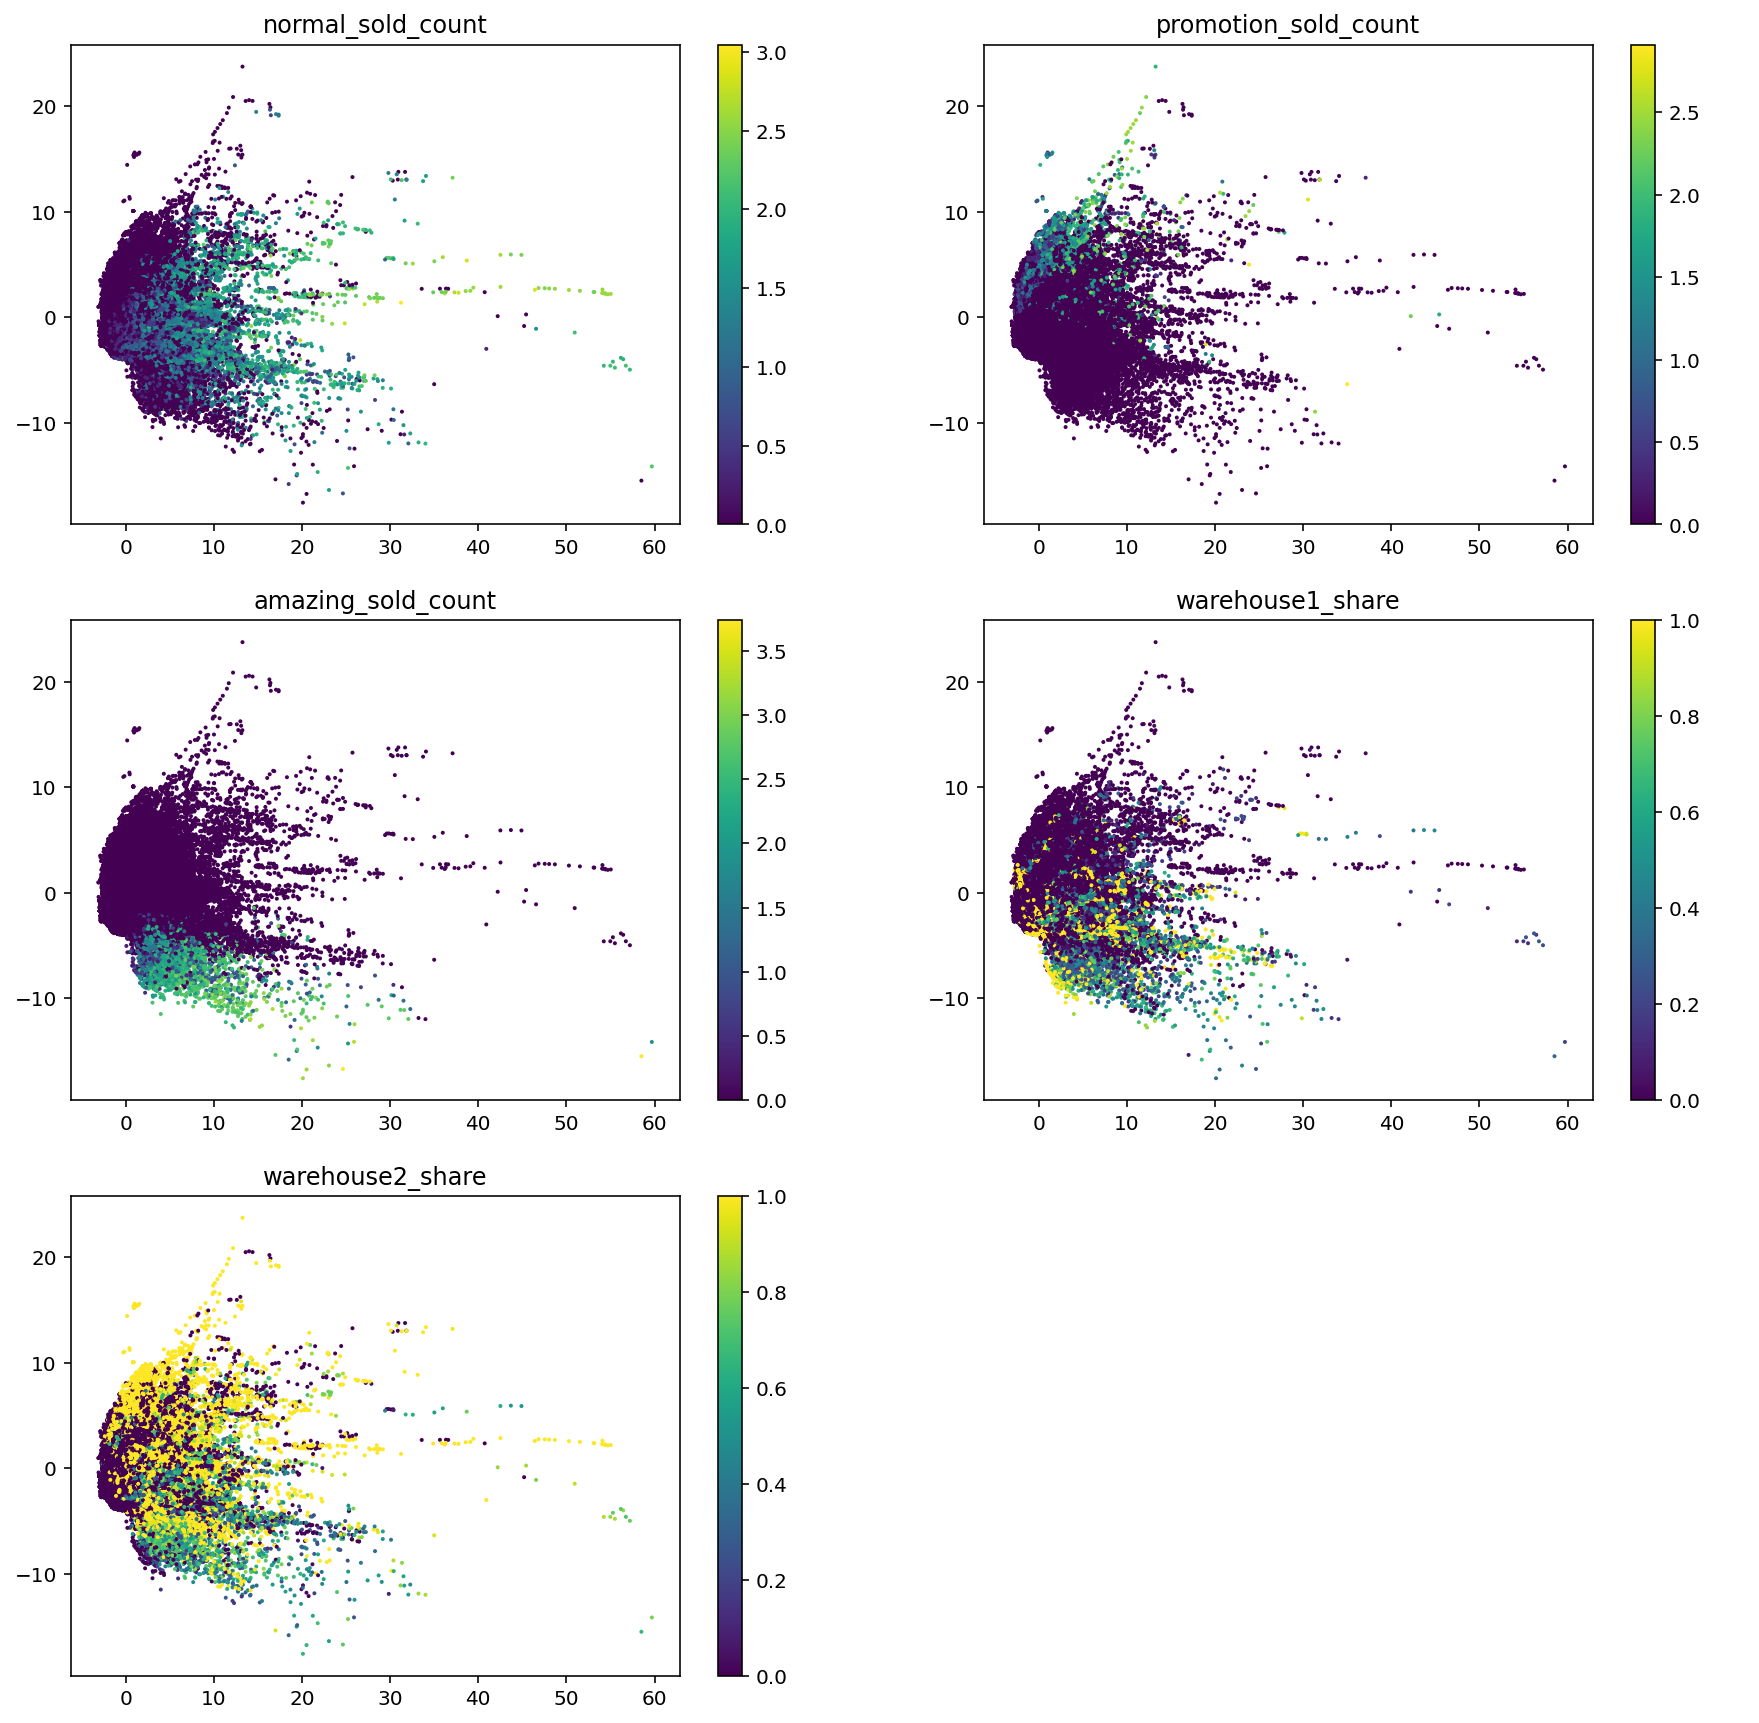

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15));

for i, axsi in enumerate(axs):
  for j, ax in enumerate(axsi):
    idx = i * len(axs[0]) + j
    if idx >= len(target_cols):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_axis_off()
      continue
    col = target_cols[idx]
    color = y_train[col]
    if col.endswith('count'):
      color = np.log10(1 + color)
    p = ax.scatter(x_train_2d_pca[:, 0], x_train_2d_pca[:, 1], s=1, c=color);
    fig.colorbar(p, ax=ax);
    ax.set_title(col);

# 5. Identifiying abnormal samples

In [ ]:
outlier_detector = OneClassSVM('linear')

In [ ]:
train_is_inlier = outlier_detector.fit_predict(x_train)

In [ ]:
print('Number of outliers =', (train_is_inlier == -1).sum())

In [ ]:
plt.scatter(x_train_2d_pca[:, 0], x_train_2d_pca[:, 1], s=1, c=train_is_inlier==-1, label='train');
plt.legend();

In [ ]:
train_df = train_df[train_is_inlier == 1]
x_train = x_train[train_is_inlier == 1]
y_train = y_train[train_is_inlier == 1]
x_train_2d_pca = x_train_2d_pca[train_is_inlier == 1]

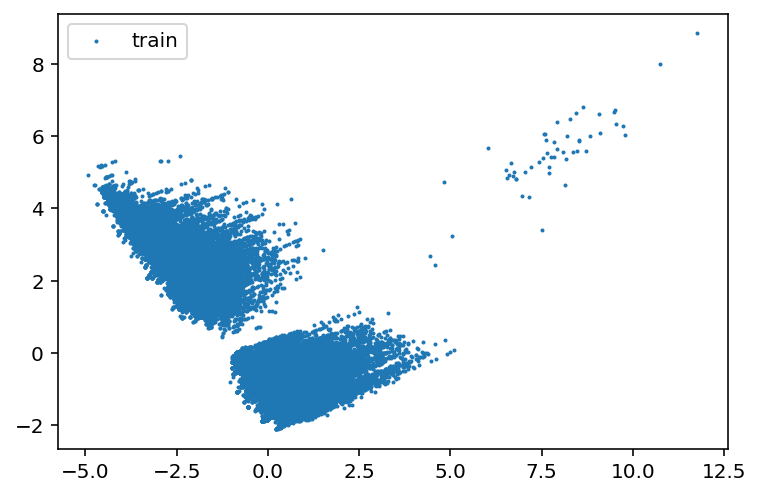

In [ ]:
plt.scatter(x_train_2d_pca[:, 0], x_train_2d_pca[:, 1], s=1, label='train');
plt.legend();

# 6.2. Feature Selection

In [ ]:
feature_selector = SelectKBest(f_regression, k=100)
x_train_np = feature_selector.fit_transform(x_train, y_train[target_cols[0]])

In [ ]:
remaining_feautre_names = x_train.columns[feature_selector.get_support()]

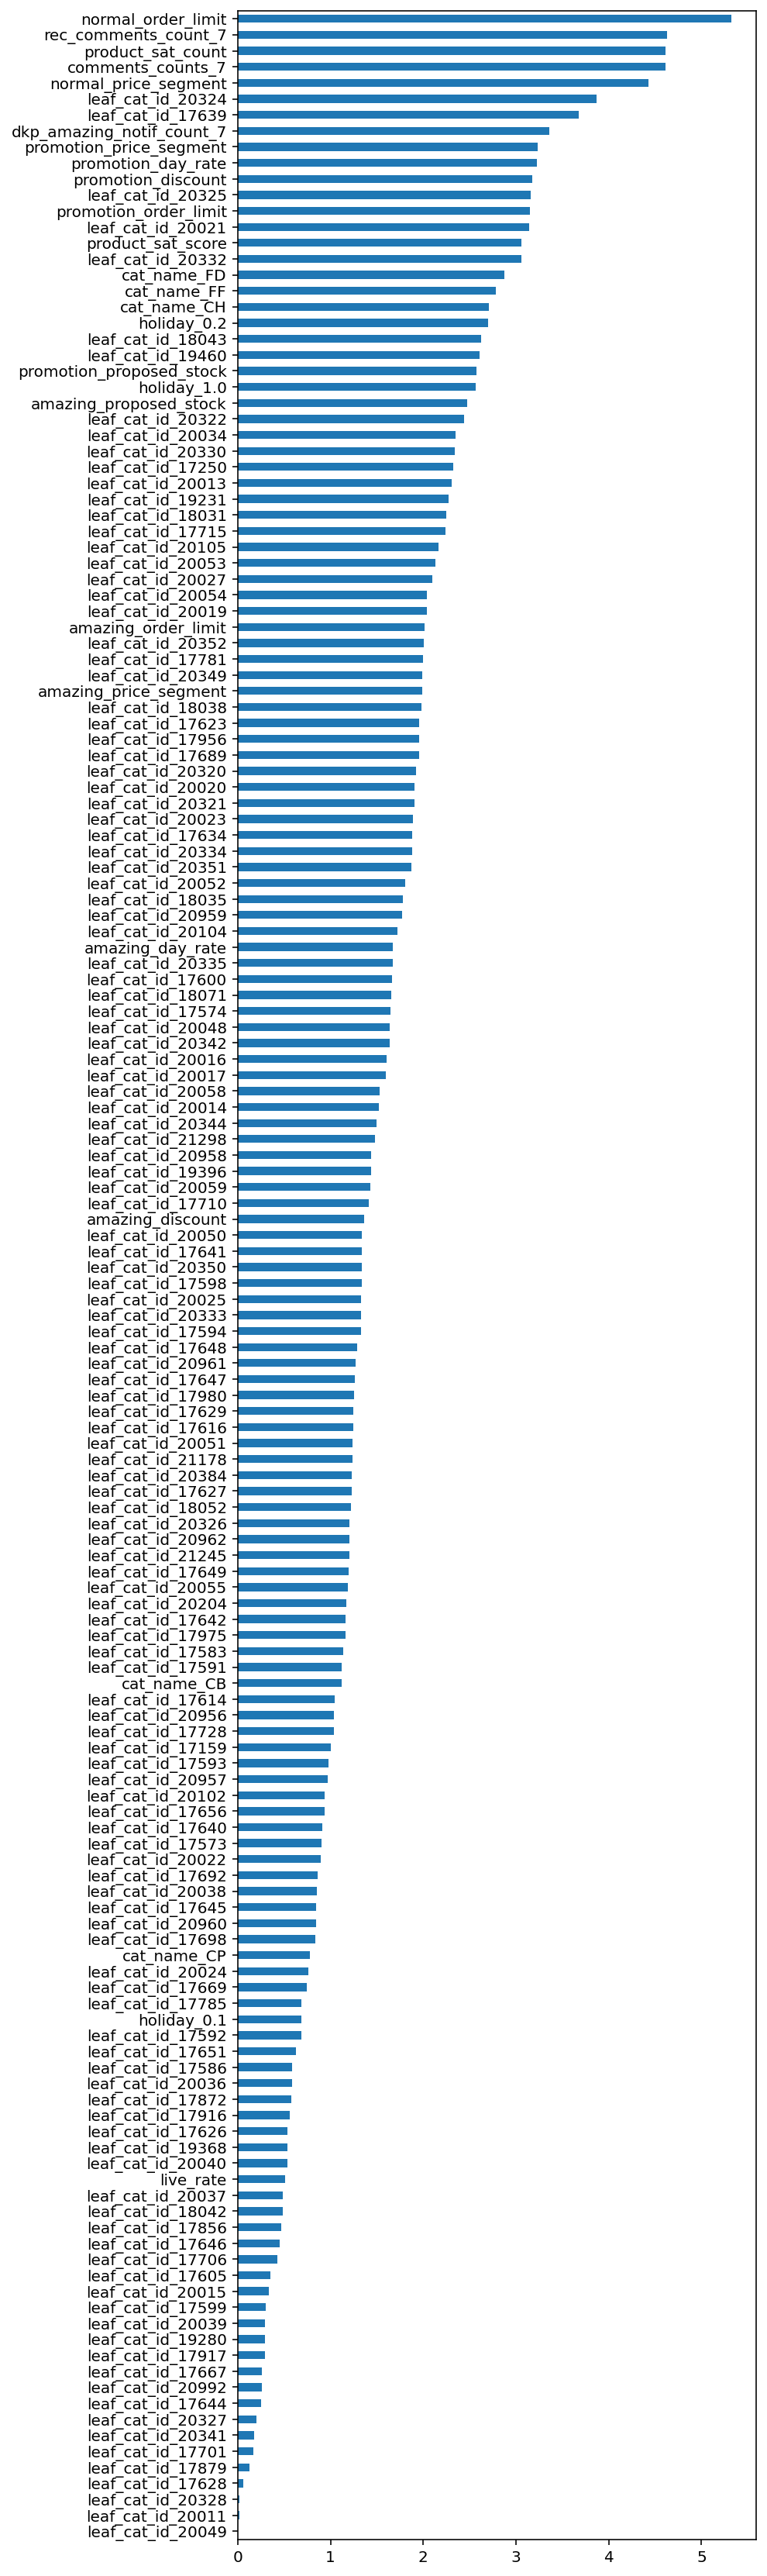

In [ ]:
pd.Series(np.log10(1+feature_selector.scores_), x_train.columns).\
          sort_values(ascending=True).plot.barh(figsize=(6, 30));

In [ ]:
x_test_np = feature_selector.transform(x_test)

In [ ]:
x_train = pd.DataFrame(x_train_np, index=x_train.index, columns=remaining_feautre_names)
x_test = pd.DataFrame(x_test_np, index=x_test.index, columns=remaining_feautre_names)

# 7. Balancing the data

# 8. Training models

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

## Linear Regression

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
%time linear_reg.fit(x_train, y_train)

CPU times: user 6.16 s, sys: 719 ms, total: 6.88 s
Wall time: 3.95 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
linear_reg.coef_.shape

(5, 183)

In [ ]:
linear_reg.score(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.6052446940199679

In [ ]:
linear_reg.score(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5914339731983883

In [ ]:
y_val_pred = linear_reg.predict(x_val)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

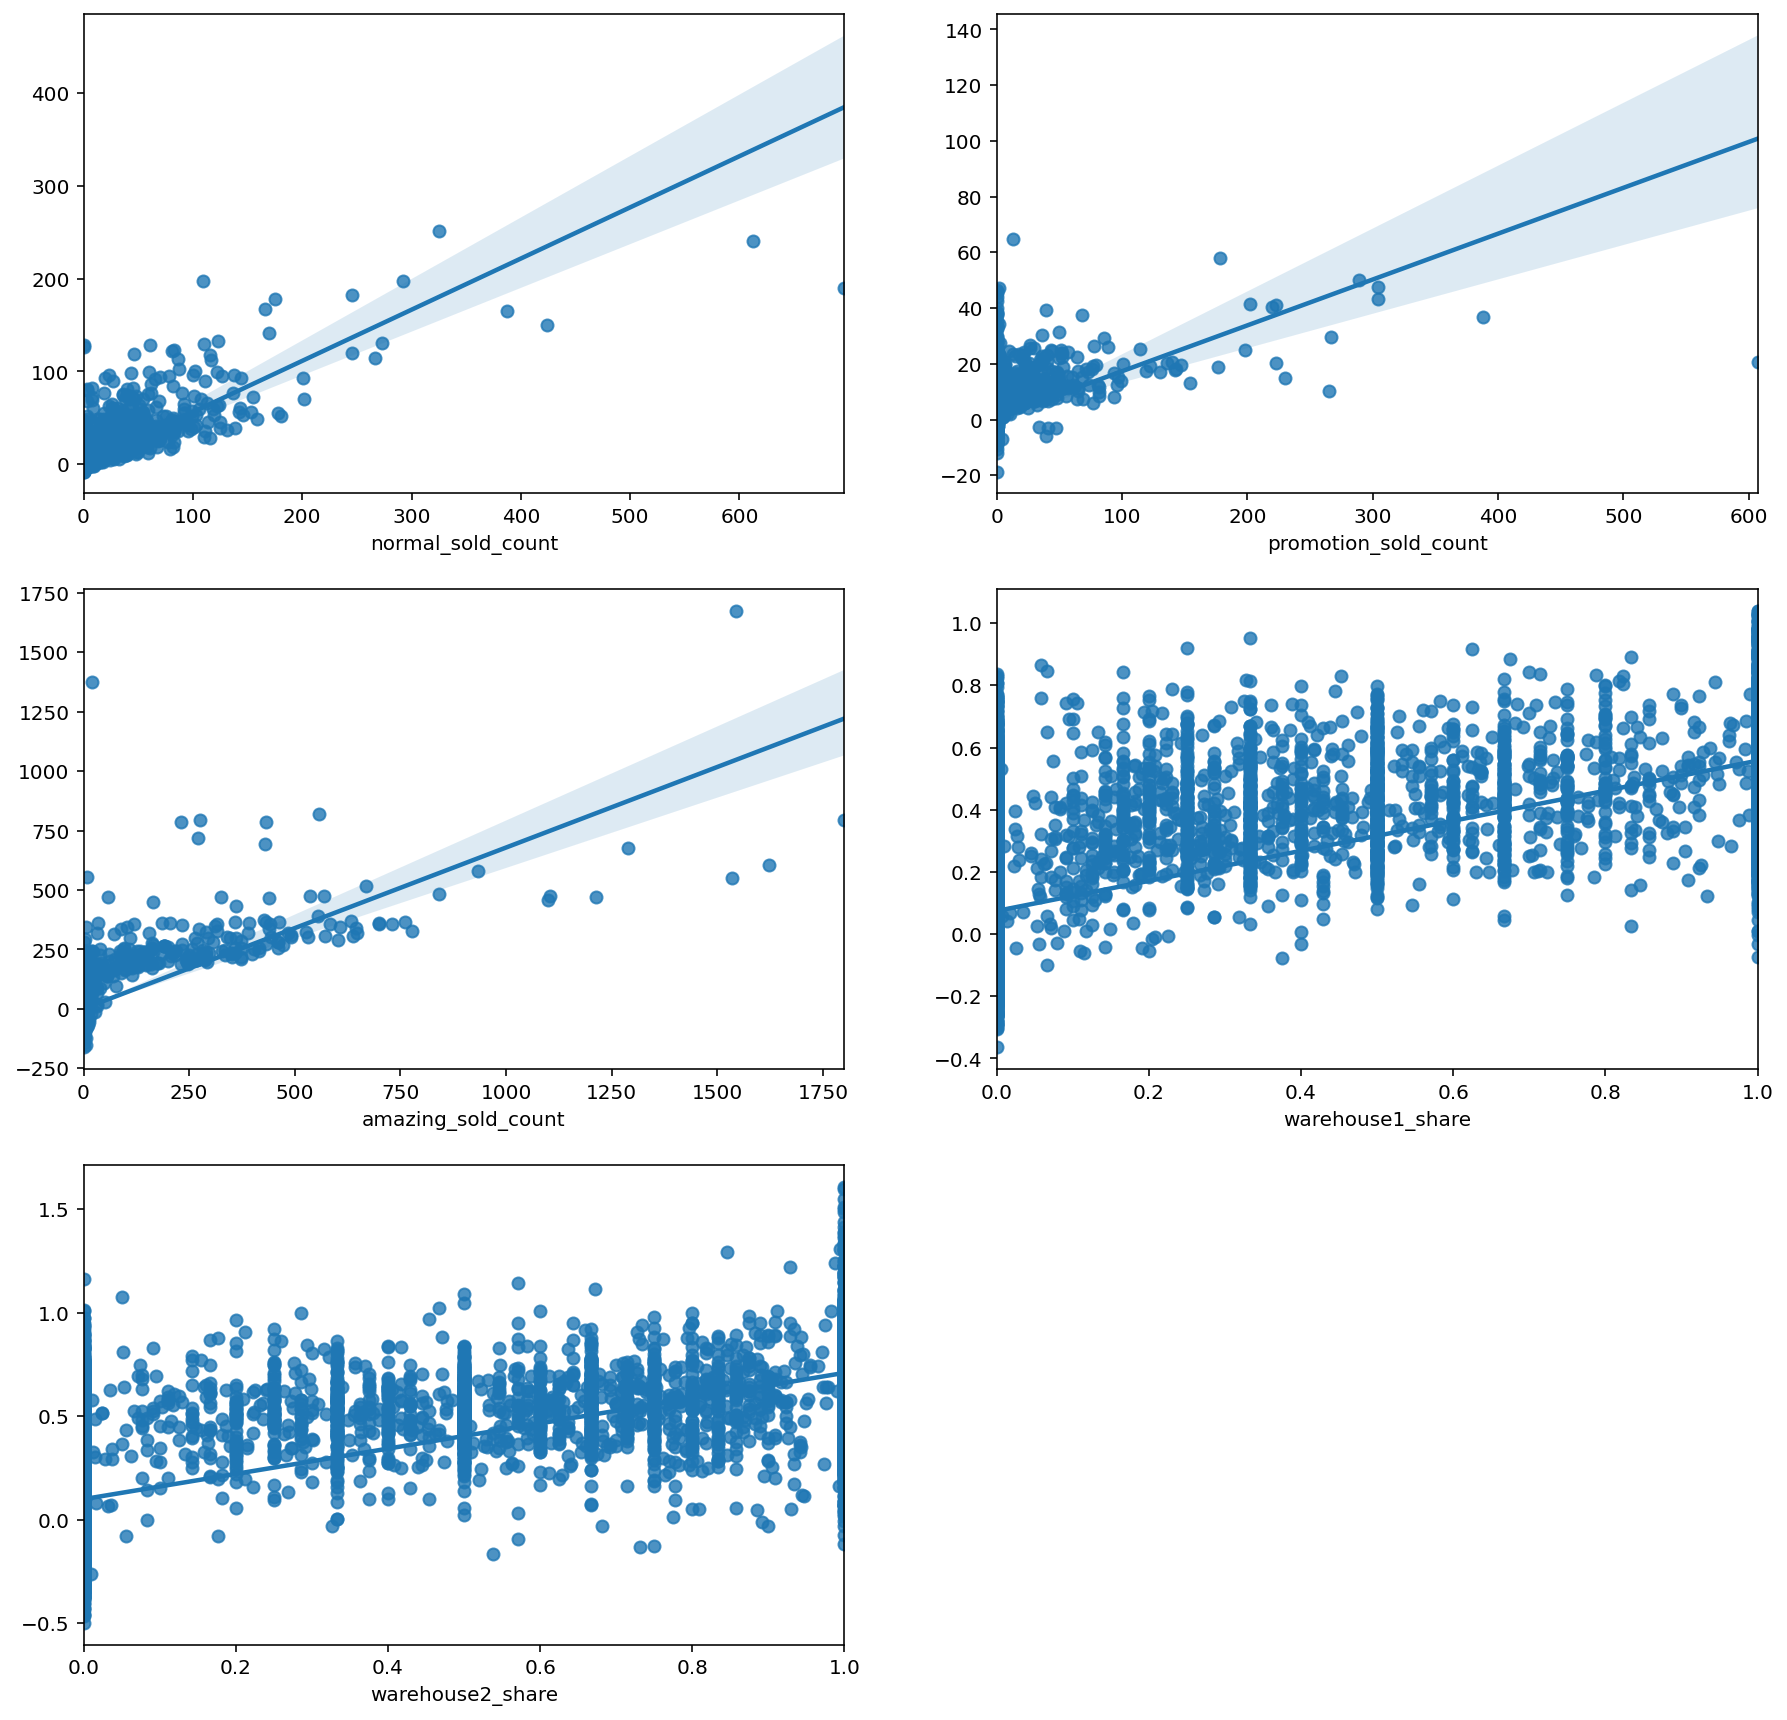

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15));

for i, axsi in enumerate(axs):
  for j, ax in enumerate(axsi):
    idx = i * len(axs[0]) + j
    if idx >= len(target_cols):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_axis_off()
      continue
    col = target_cols[idx]
    sns.regplot(y_val[col], y_val_pred[:, idx], ax=ax);

## Gradient Boosting Regression

In [ ]:
grad_boost = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, min_samples_split=3, verbose=1), n_jobs=-1)
%time grad_boost.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         129.9462            2.03m
         2         114.3224            2.01m
         3         100.2070            1.98m
         4          89.2118            2.07m
         5          79.3813            2.02m
         6          71.1181            1.99m
         7          64.3732            1.95m
         8          58.5862            1.92m
         9          53.7907            1.89m
        10          49.8219            1.86m
        20          30.2288            1.62m
        30          24.4539            1.40m
        40          21.7012            1.20m
        50          19.7736            1.01m
        60          18.3833           48.19s
        70          17.3441           36.16s
        80          16.7072           24.04s
        90          15.9683           12.01s
       100          15.3938            0.00s
      Iter       Train Loss   Remaining Time 
         1          80.6900            2.05m
        

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=3,
                                                         min_weight_fraction_

In [ ]:
grad_boost.score(x_train, y_train)

0.7669081146672072

In [ ]:
grad_boost.score(x_val, y_val)

0.6781044951983491

In [ ]:
y_val_pred = grad_boost.predict(x_val)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

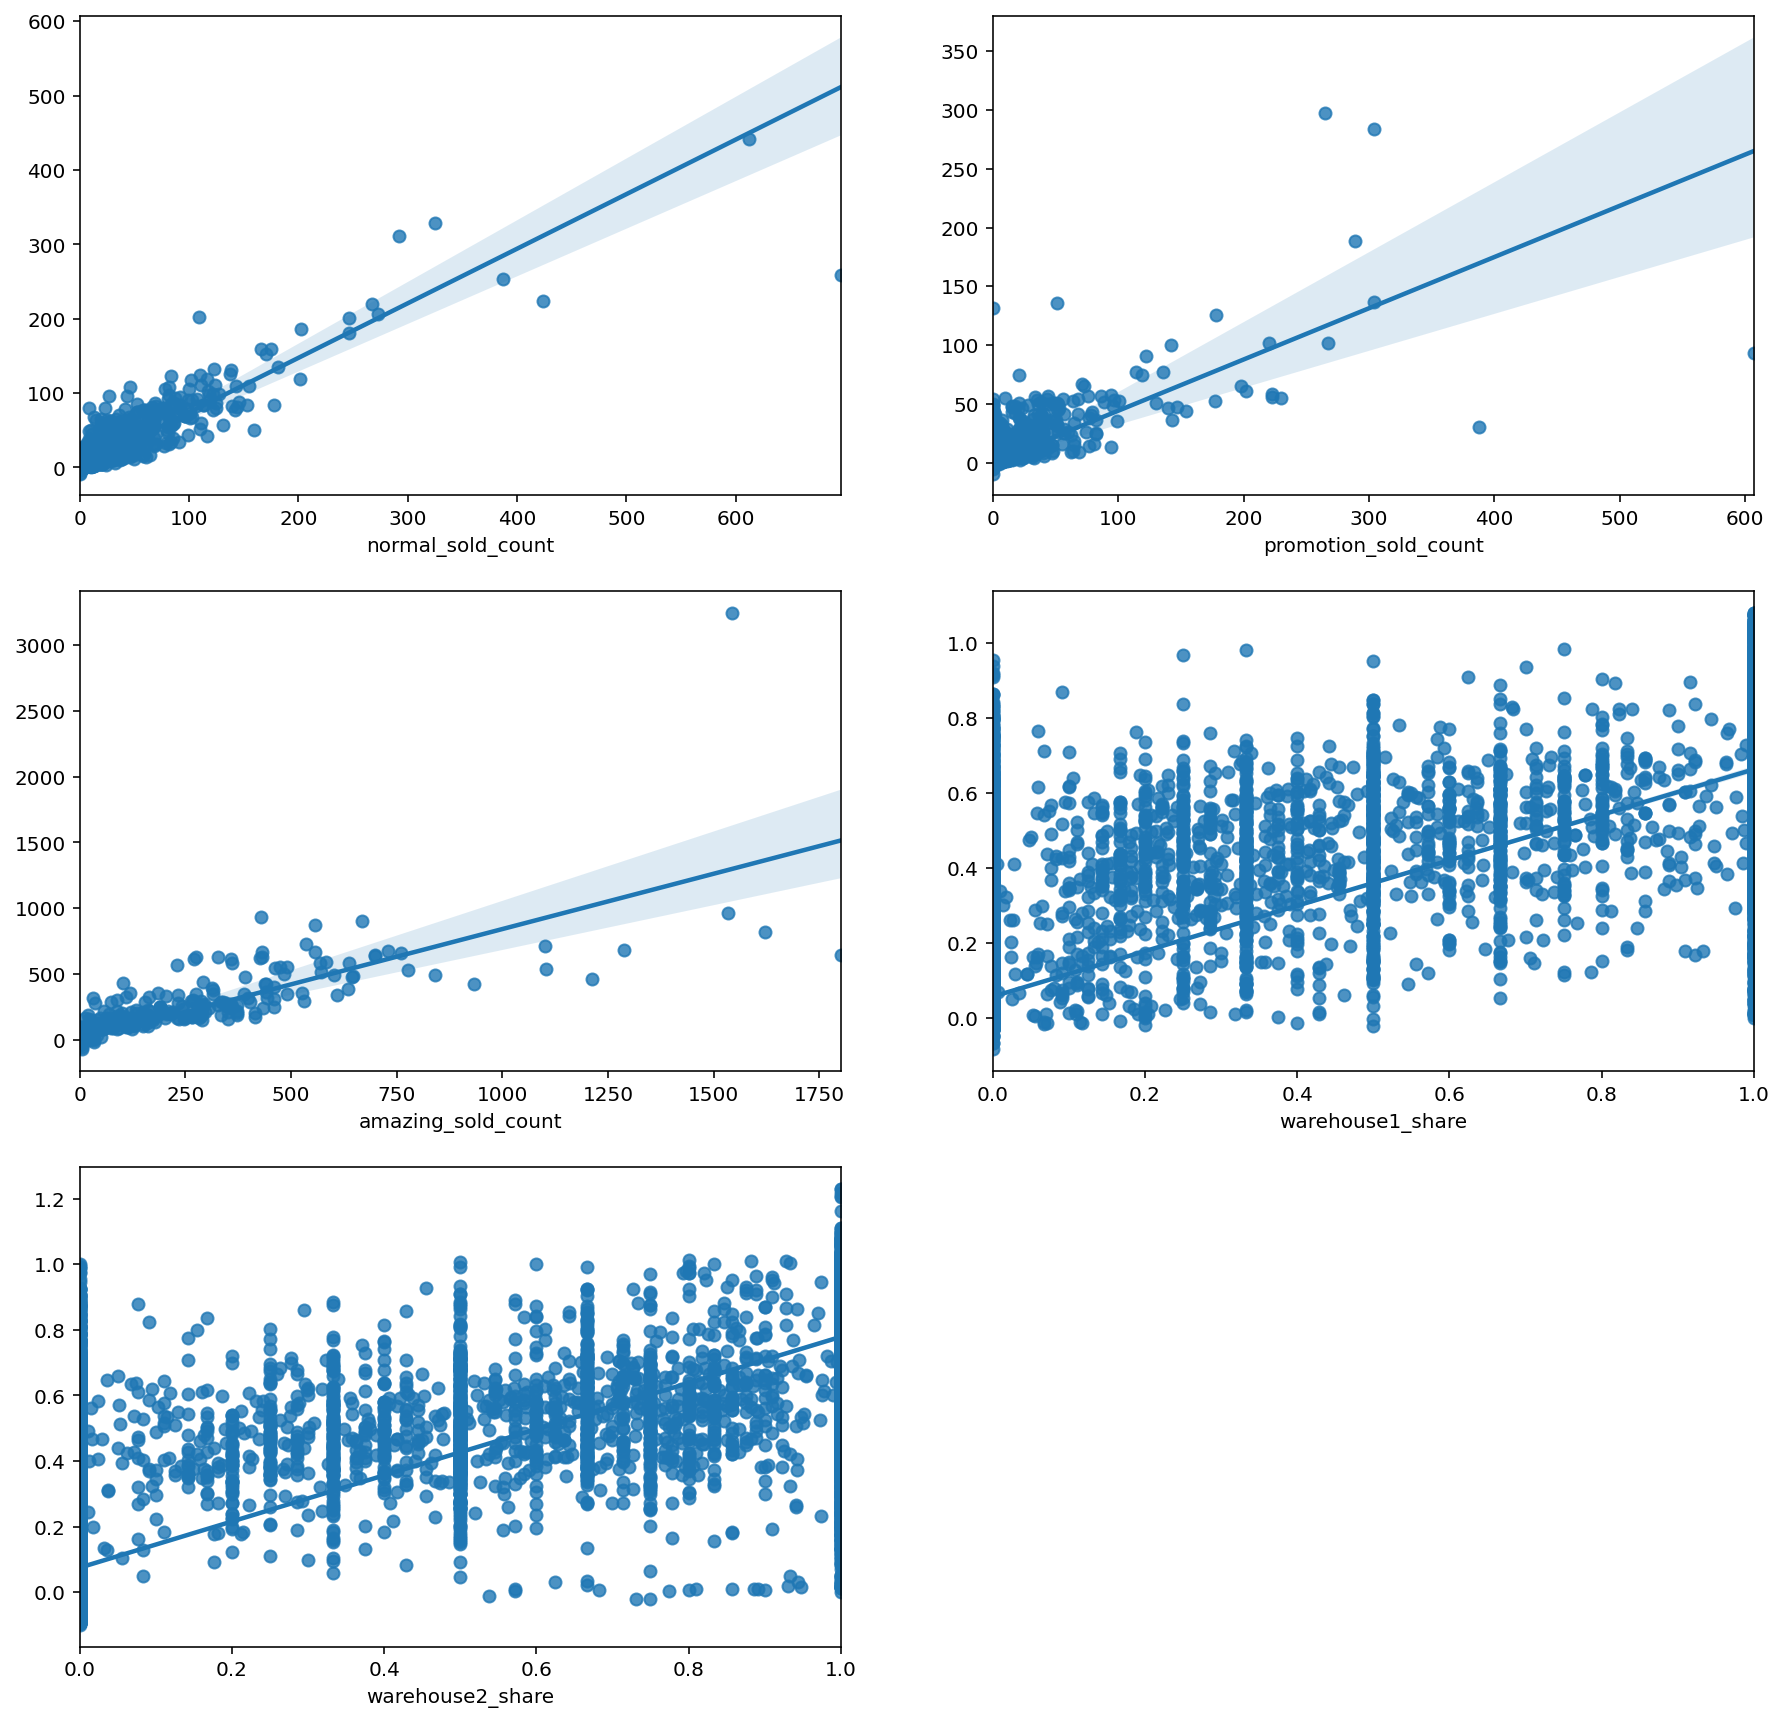

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15));

for i, axsi in enumerate(axs):
  for j, ax in enumerate(axsi):
    idx = i * len(axs[0]) + j
    if idx >= len(target_cols):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_axis_off()
      continue
    col = target_cols[idx]
    sns.regplot(y_val[col], y_val_pred[:, idx], ax=ax);

# 9. Model Analysis

## Feature Importances:

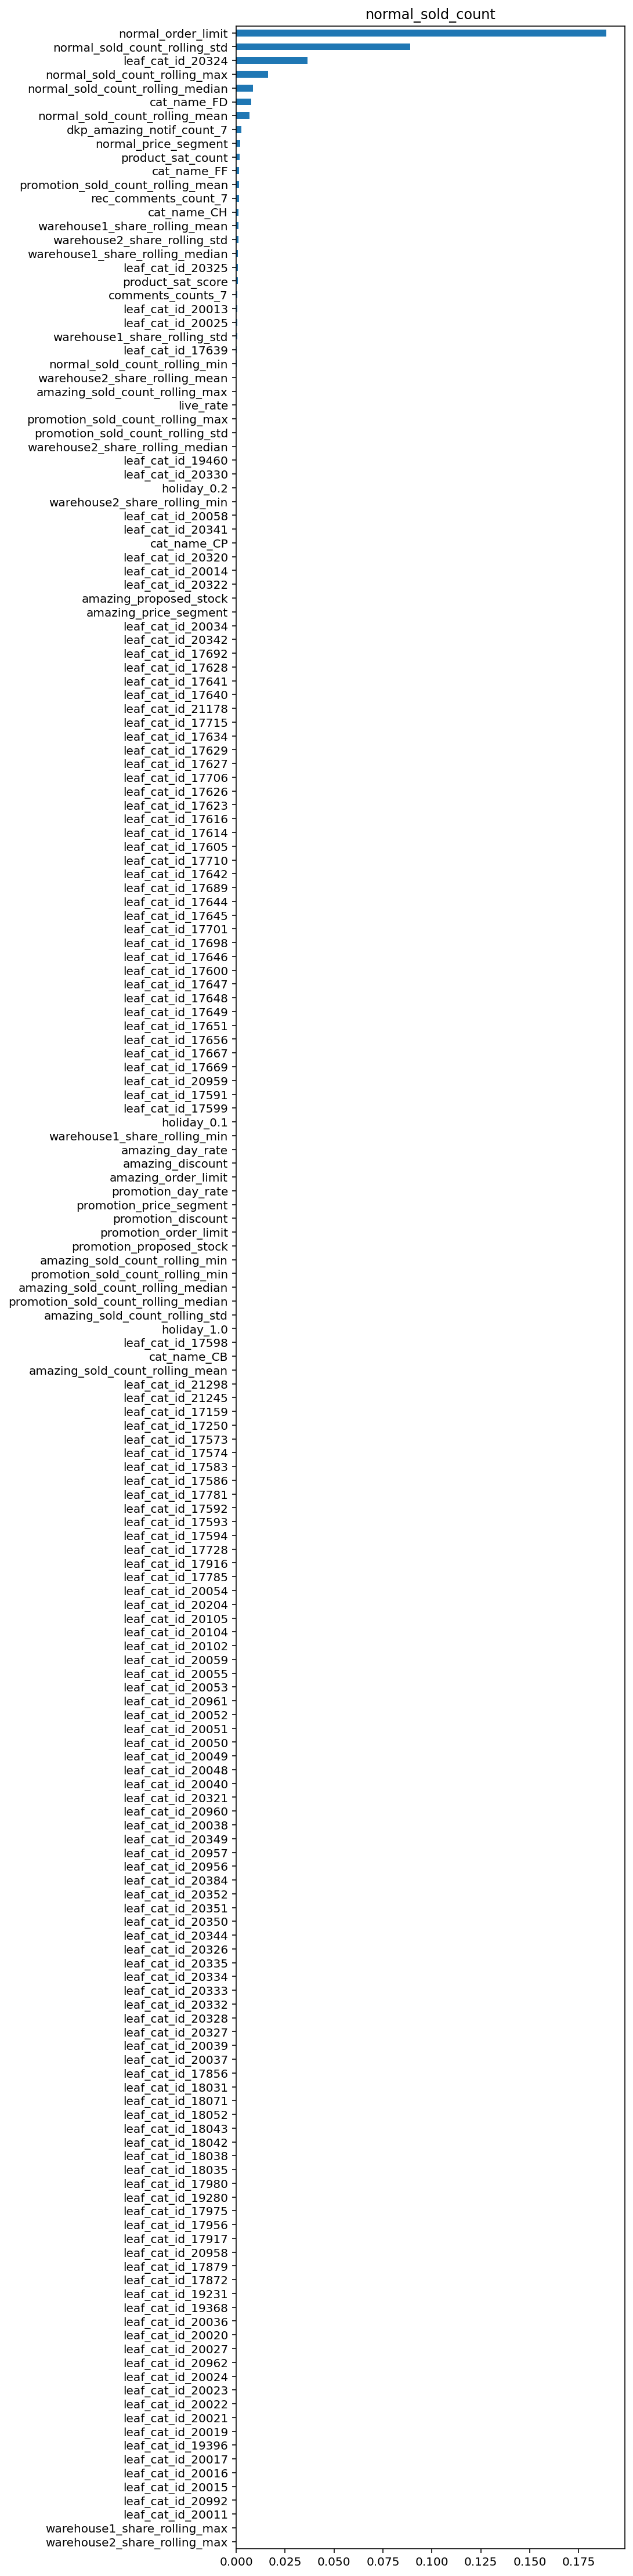

In [ ]:
pd.Series(np.log10(1+grad_boost.estimators_[0].feature_importances_), index=x_train.columns).sort_values().\
          plot.barh(figsize=(6, 40));
plt.title(target_cols[0]);

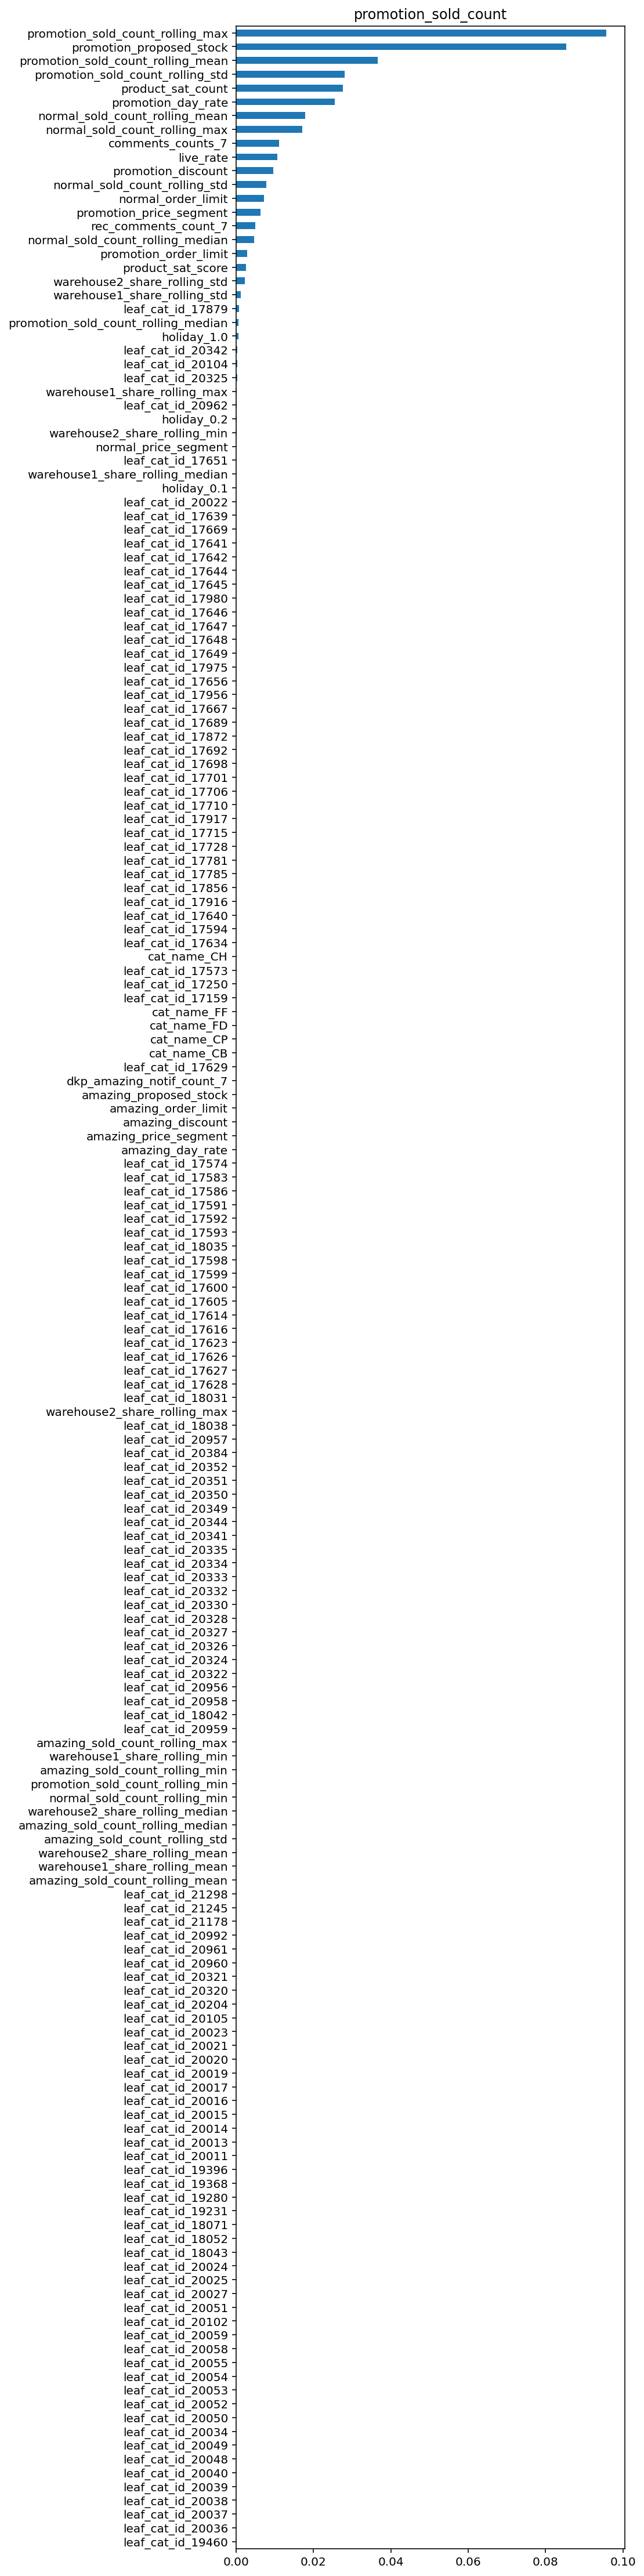

In [ ]:
pd.Series(np.log10(1+grad_boost.estimators_[1].feature_importances_), index=x_train.columns).sort_values().\
          plot.barh(figsize=(6, 40));
plt.title(target_cols[1]);

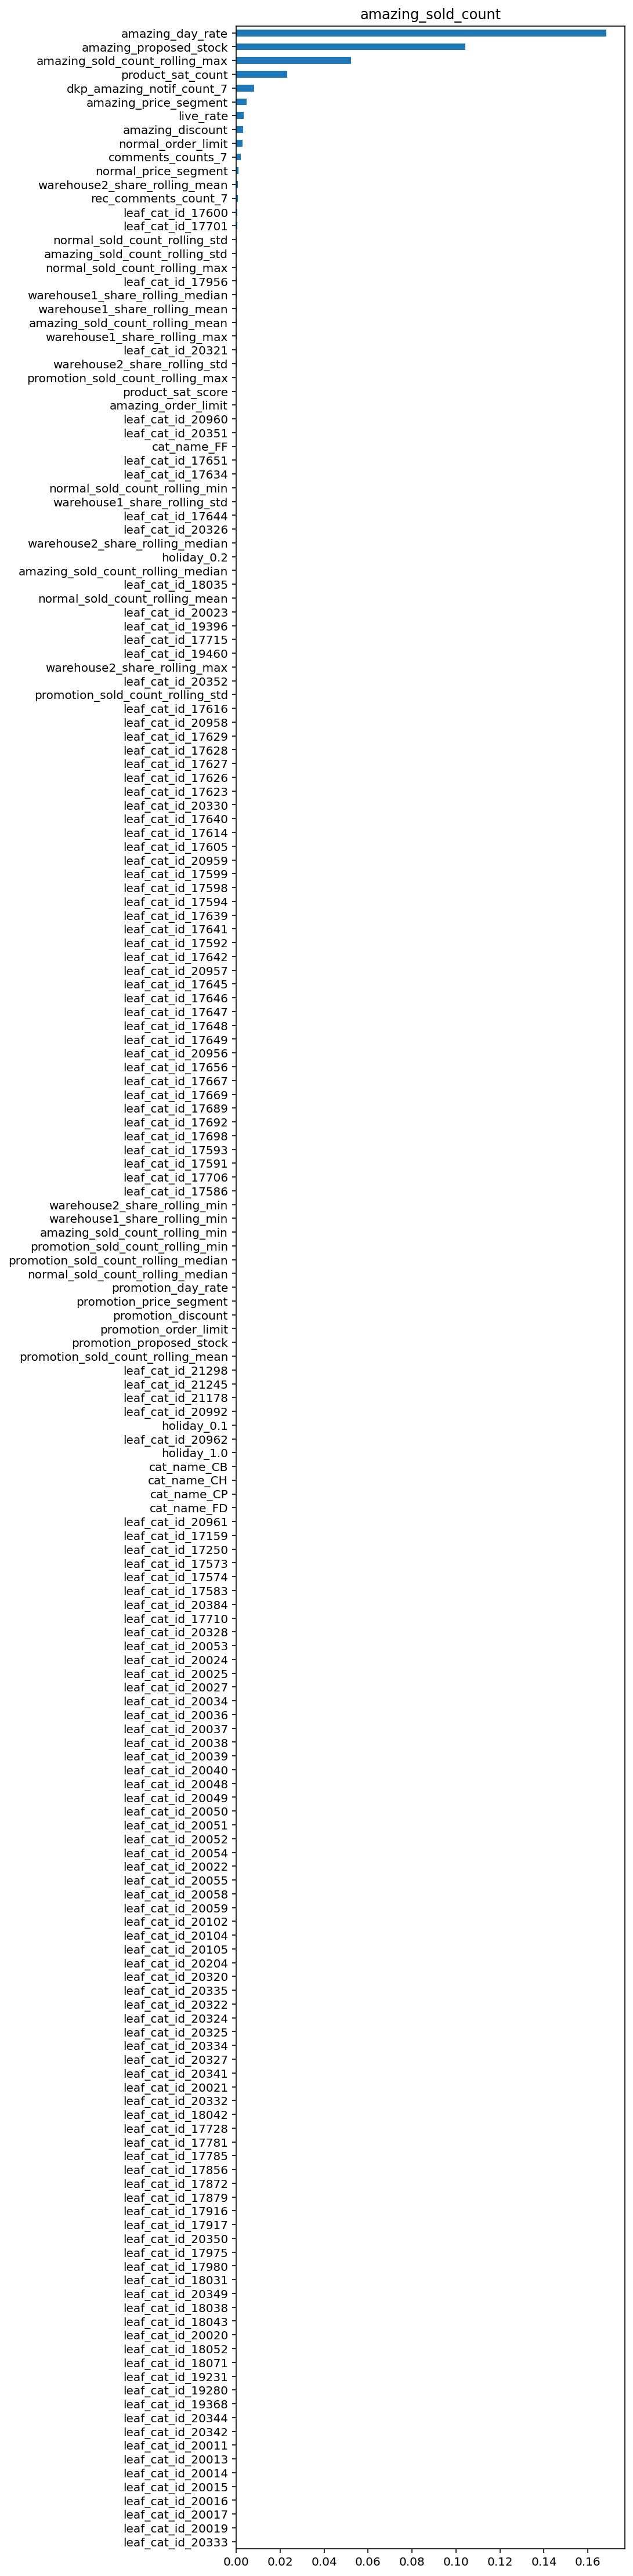

In [ ]:
pd.Series(np.log10(1+grad_boost.estimators_[2].feature_importances_), index=x_train.columns).sort_values().\
          plot.barh(figsize=(6, 40));
plt.title(target_cols[2]);

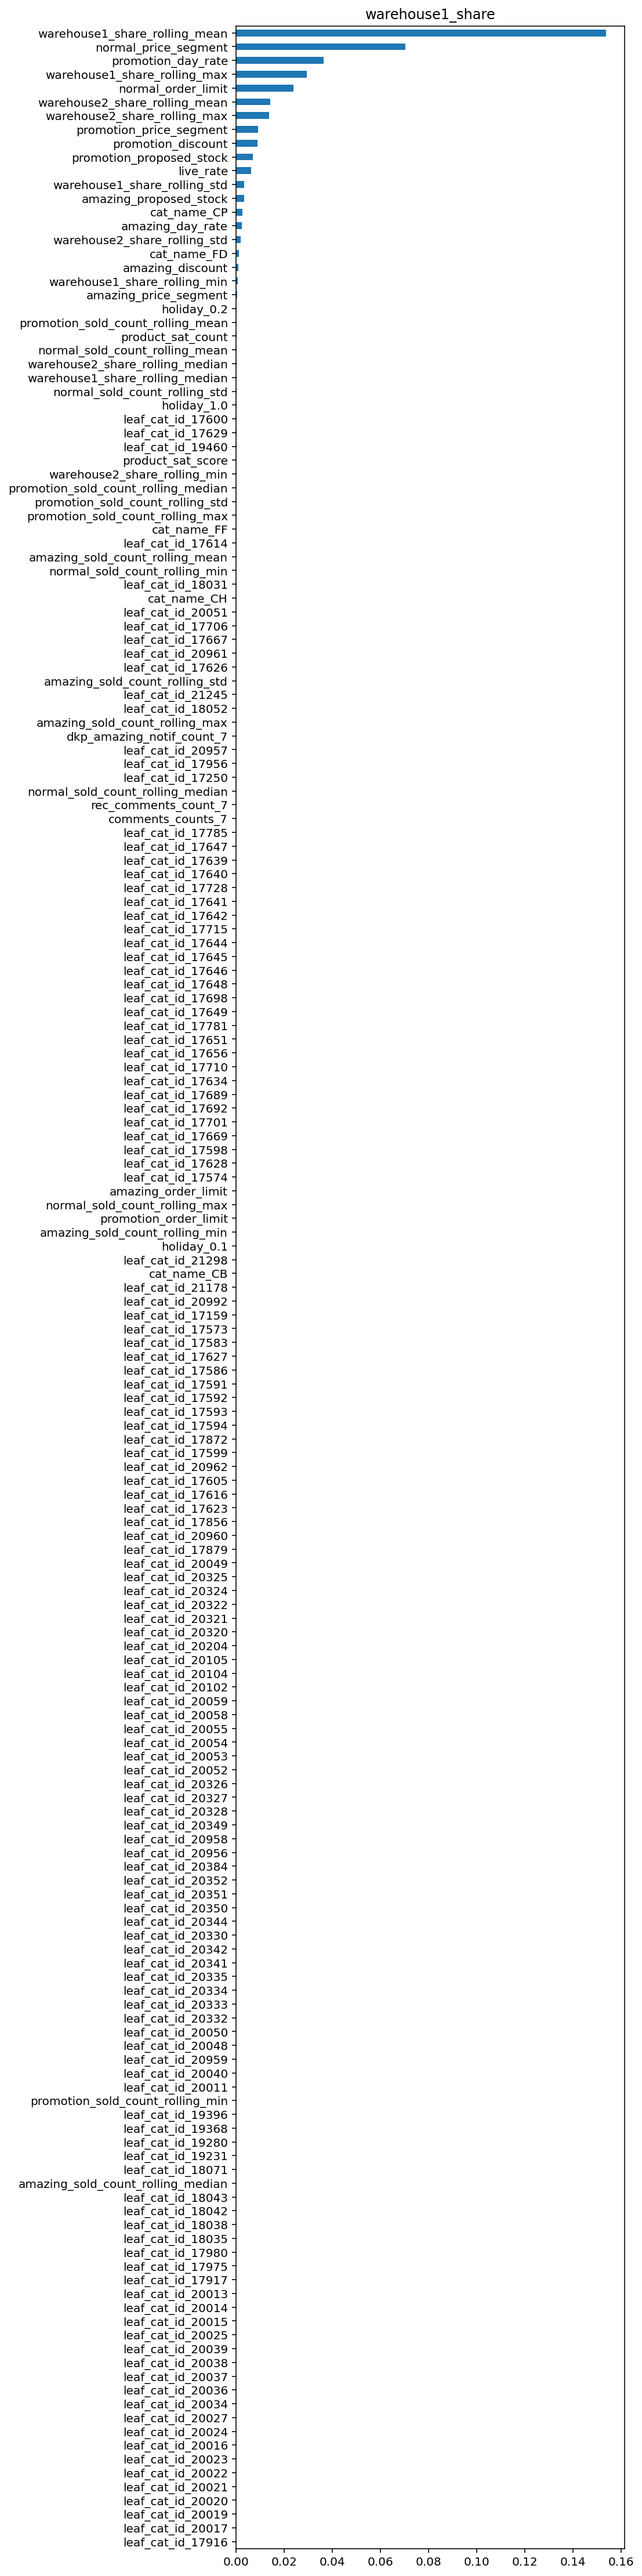

In [ ]:
pd.Series(np.log10(1+grad_boost.estimators_[3].feature_importances_), index=x_train.columns).sort_values().\
          plot.barh(figsize=(6, 40));
plt.title(target_cols[3]);

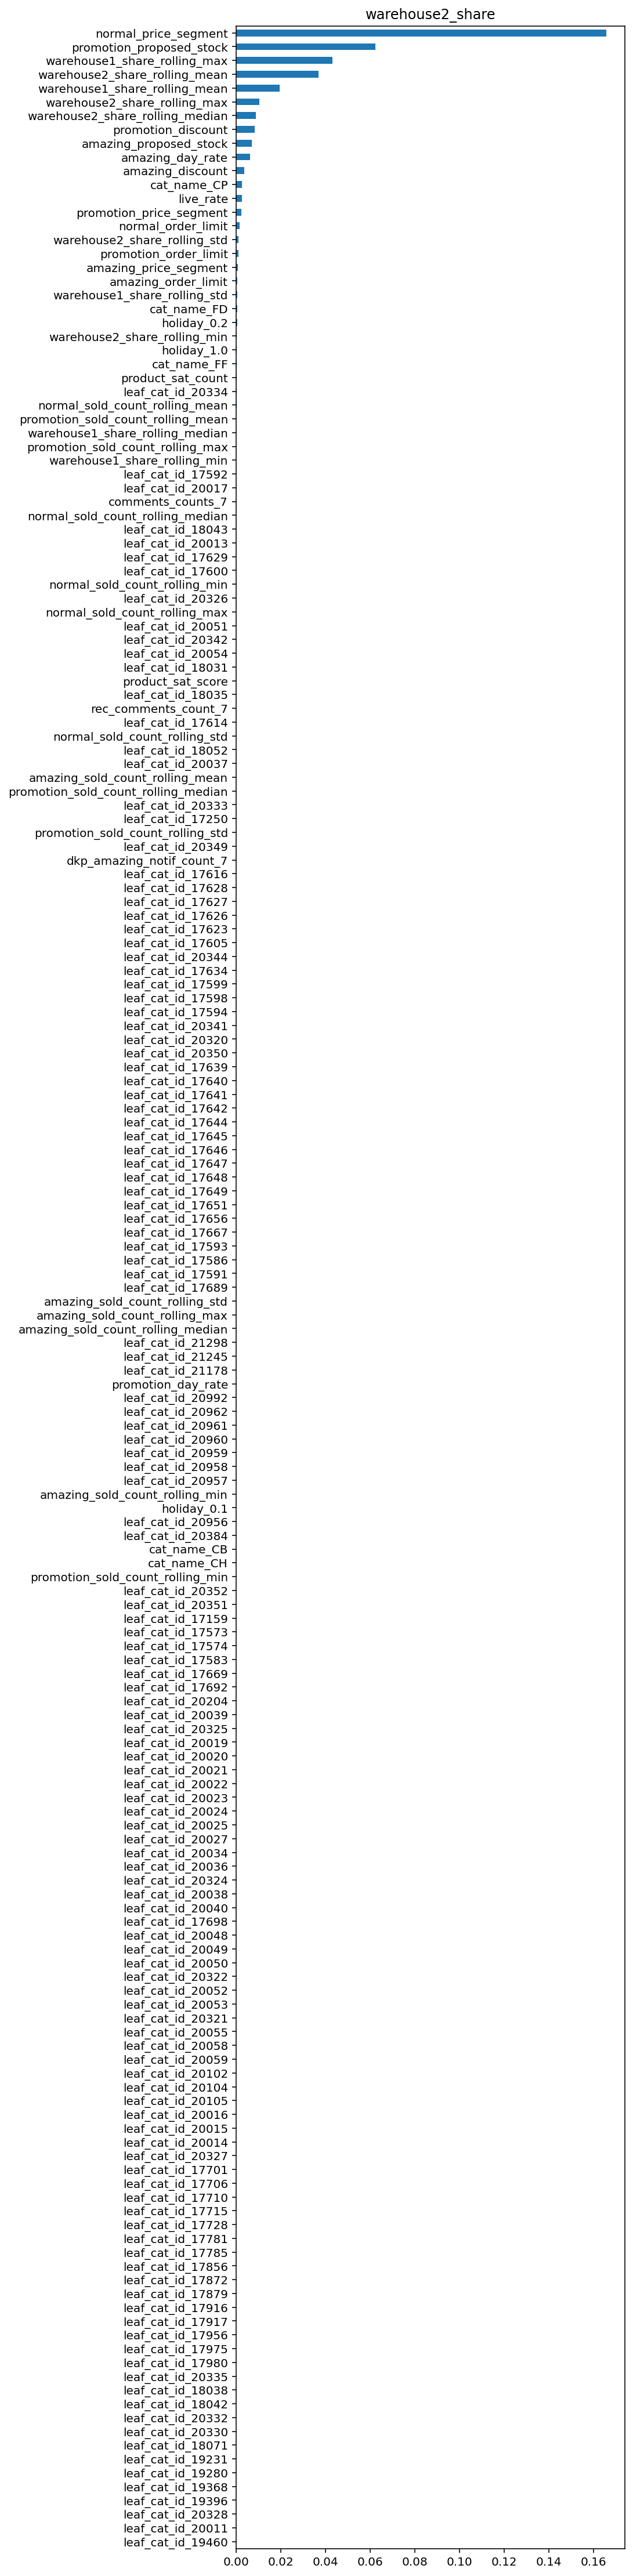

In [ ]:
pd.Series(np.log10(1+grad_boost.estimators_[4].feature_importances_), index=x_train.columns).sort_values().\
          plot.barh(figsize=(6, 40));
plt.title(target_cols[4]);